# PR Facebook EDA
EDA for Facebook data: round 2.

- RQ1: does toponym information status (measured by appositives, adjoining NP?) change over course of crisis?
- RQ2: does toponym information status vary by person or audience?

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
import csv

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# load data
fb_data = pd.read_csv('../../data/facebook-maria/combined_group_data.tsv', sep='\t', index_col=False)
print("%d posts and comments"%(fb_data.shape[0]))
## split Spanish data
fb_data_es = fb_data[fb_data.loc[:, 'status_lang']=='es']
print('%d posts and comments in Spanish'%(fb_data_es.shape[0]))

31413 posts and comments
23662 posts and comments in Spanish


In [3]:
display(fb_data.head())

,group_id,status_author_id,status_message,status_lang,status_id,status_published
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34
2,351272391991842,10215020607489848,One unsafe well in Dorado on Carr 694 km 4.5,en,351272391991842_361487960970285,2017-10-17 20:20:03
3,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08
4,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22


In [232]:
# import re
# from collections import Counter
# from functools import reduce
# word_counts = Counter(reduce(lambda x,y: x+y, fb_data_es.loc[:, 'status_message'].apply(lambda x: x.lower().split(' '))))
# word_counts = pd.Series(word_counts).sort_values(ascending=False, inplace=False)
print(word_counts[list(filter(lambda x: '.' in x, word_counts.index))][100:150])

lajas.                                        48
4.                                            47
mucho.                                        47
utuado.                                       46
area.                                         46
dias.                                         45
noticias.                                     45
café.                                         45
dr.                                           45
voz.                                          44
conmigo.                                      44
p.r.                                          44
ortiz.                                        44
llamar.                                       44
área.                                         44
torres.                                       42
persona.                                      42
desesperada.                                  41
10.                                           41
también.                                      41
comunicarse.        

### Clean text

There are some conjoined words due to the removal of return characters (e.g. "CayeyPuerto Rico"), and the tokenization ends up splitting common abbreviations like "bo." ("barrio"), "carr." ("carretera"), "ave" ("avenida"), "esc." ("escuela"), "urb" ("urbanizacion"), "esq." ("esquina"), "sr" ("senor"), "sra" ("senora")...

## Identify toponyms
Let's try tagging all NEs and picking out the toponyms.

If this doesn't work, we can try parsing and picking out locative PPs.

Run the NLTK server as follows:

```
cd /hg190/corpora/StanfordCoreNLP/stanford-corenlp-full-2018-02-27
java -Xmx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -serverProperties StanfordCoreNLP-spanish.properties -preload tokenize,ssplit,pos,ner,parse -status_port 9003  -port 9003 -timeout 15000
```

In [233]:
from importlib import reload
import nltk
reload(nltk)
from nltk.parse.corenlp import CoreNLPParser
parser = CoreNLPParser(url='http://localhost:9003', tagtype='ner')
# tagger = StanfordNERTagger('http://localhost:9003')

In [5]:
## tokenize first
sents = fb_data_es.loc[:, 'status_message'].iloc[:5]
for sent_i in sents:
#     print(sent_i)
    sent_i_tokens = parser.tokenize(sent_i)
    # NER tag
    sent_i_tags = parser.tag(sent_i_tokens)
    sent_i_tags = ' '.join(['/'.join(x) for x in sent_i_tags])
    print(sent_i_tags)

Estoy/O preocupada/O por/O mi/O tia/O vicky/O vazquez/O que/O desde/O el/O dia/O antes/O de/O el/O huracan/O no/O se/O de/O ella/O pues/O ella/O es/O una/O mujer/O enferma/O tiene/O que/O usar/O oxijeno/O y/O ella/O me/O dijo/O el/O dia/O antes/O de/O el/O huracan/O que/O su/O oxijeno/O se/O avia/O acabado/O y/O que/O no/O se/O sentia/O bien/O pero/O que/O se/O estava/O dando/O terapias/O con/O la/O maquina/O de/O el/O asma/CAUSE_OF_DEATH ella/O vive/O en/O higuillar/O en/O Dorado/ORGANIZATION creo/O qye/O se/O llama/O arenar/O en/O la/O calle/O que/O vive/O a/O el/O frente/O de/O su/O casa/O antes/O hera/O una/O vaqueria/O yo/O espero/O que/O ella/O este/O bien/O por/O favor/O si/O alguien/O de/O el/O grupo/O es/O de/O esa/O aria/O y/O la/O conose/O diga/O le/O que/O su/O sobrina/O la/O esta/O buscando/O gracias/O por/O favor/O de/O compartir/O
Para/O alguien/O que/O lo/O necesite/O .../O Da/O le/O Share/MISC ./O ./O A/O todos/O nuestros/O amigos/O ,/O pacientes/O y/O a/O el/O publico

- "Dorado" = `Organization`
- "Caguas" = `Location`
- "Turabo Gardens" = `Organization`
- "Cordero" = `Organization`

Let's tag everything and see what the most common NEs are by type. That should help us figure out how to isolate toponyms.

In [ ]:
%%capture tag_output
sent_tags = []
for i, sent_i in enumerate(fb_data_es.loc[:, 'status_message']):
    sent_i_tokens = list(parser.tokenize(sent_i))
    if(len(sent_i_tokens) > 0):
        sent_i_tags = parser.tag(sent_i_tokens)
    else:
        sent_i_tags = []
    sent_tags.append(sent_i_tags)
    if(i % 500 == 0):
        print('processed %d sents'%(i))
fb_data_es.loc[:, 'status_message_tags'] = sent_tags

In [ ]:
## filter NEs
## TODO: update this with BIO tags so we avoid NE collision ("Dorado Dorado")
def extract_NEs(tags):
    curr_tag = ''
    curr_ne = []
    ne_list = []
    for word, tag in tags:
#         print('word %s tag %s curr_tag %s'%(word, tag, curr_tag))
        if(tag != 'O'):
            if(curr_tag != '' and tag != curr_tag and len(curr_ne) > 0):
                curr_ne = (' '.join([x for x,y in curr_ne]), curr_ne[0][1]) # save (word,tag)
                ne_list.append(curr_ne)
#                 print('adding curr NE to list: %s'%(str(curr_ne)))
                curr_ne = []
            curr_ne.append((word, tag))
#             print('updating curr ne')
        elif(tag != curr_tag and curr_tag != ''):
            curr_ne = (' '.join([x for x,y in curr_ne]), curr_ne[0][1]) # save (word,tag)
            ne_list.append(curr_ne)
#             print('adding curr NE to list: %s'%(str(curr_ne)))
            curr_ne = []
        curr_tag = tag
    return ne_list
tags_i = fb_data_es.iloc[1, :].loc['status_message_tags']
fb_data_es.loc[:, 'status_message_tags_ne'] = fb_data_es.loc[:, 'status_message_tags'].apply(lambda x: extract_NEs(x))

## Explore NEs

Let's see the most common NEs overall.

In [ ]:
from functools import reduce
fb_data_es_nes = [[y for y in x] for x in fb_data_es.loc[:, 'status_message_tags_ne'].values]
fb_data_es_nes = list(reduce(lambda x,y: x+y, fb_data_es_nes))
fb_data_es_nes = pd.Series(fb_data_es_nes)
print('%d NEs total'%(len(fb_data_es_nes)))
display(fb_data_es_nes.value_counts().head(20))

Surprise! Most common NEs are well-known locations like `Puerto Rico`, `Guayama`, `Quebradillas`.

What are the most common NEs by type?

In [ ]:
fb_data_es_ne_data = pd.DataFrame(list(zip(*fb_data_es_nes)), index=['name', 'tag']).transpose()
print(fb_data_es_ne_data.head())
# list(zip(*fb_data_es_nes))[1][:5]

In [11]:
for t, data_t in fb_data_es_ne_data.groupby('tag'):
    print('tag=%s'%(t))
    display(data_t.loc[:, 'name'].value_counts().head(10))

tag=CAUSE_OF_DEATH


huracán         426
desastre         90
inundaciones     73
tormenta         47
enfermedades     30
diabetes         27
fuego            25
huracanes        21
enfermedad       21
Huracán          21
Name: name, dtype: int64

tag=CITY


Alta         339
San          278
San Juan     257
Baja         215
Corozal      135
Isabela      115
Orlando      109
Naranjito     96
Palo          86
Barrancas     85
Name: name, dtype: int64

tag=COUNTRY


Puerto Rico       1549
Estados Unidos     153
Palestina           55
Corea               43
EEUU                28
Cuba                18
Alemania            16
Honduras            15
México              14
Puerto rico         12
Name: name, dtype: int64

tag=CRIMINAL_CHARGE


fraude        3
delitos       2
tren          1
asalto        1
calumnia      1
Invasión      1
invasión      1
tortura       1
vandalismo    1
Name: name, dtype: int64

tag=DATE


hoy             676
mañana          250
Hoy             248
ayer            183
el martes        95
el lunes         52
Ayer             48
Mañana           46
el miércoles     27
el sábado        27
Name: name, dtype: int64

tag=DURATION


20 days       3
6 days        2
48            2
12            2
1 week        1
8 days        1
1 minute      1
5             1
10            1
60 minutes    1
Name: name, dtype: int64

tag=IDEOLOGY


espíritu       17
Carmelita      15
soto           12
carmelita       7
demócratas      2
dominicanos     2
CARMELITA       1
clase media     1
Soto            1
Espíritu        1
Name: name, dtype: int64

tag=LOCATION


Guayama         863
Coamo           464
Barranquitas    462
Vega            448
Quebradillas    377
Yabucoa         303
Barrio          268
Cayey           252
Cidra           207
Isla            189
Name: name, dtype: int64

tag=MISC


Gracias               1224
Jardines               205
Calle                  111
EmergenciasHatillo     106
Camino                  88
Ponce                   84
Pueblo                  76
Familia                 76
Juncal                  72
Diego                   72
Name: name, dtype: int64

tag=MONEY


# 2        154
# 985       56
# 3         43
# 1         38
# 14        21
$ 500       21
$ 5.00      21
# 110       21
$ 5         20
$ 15.00     14
Name: name, dtype: int64

tag=NATIONALITY


puertorriqueño    20
español           19
inglés            18
Puertorriqueño    13
Cubano             9
Portugués          4
Español            4
polo               4
lao                3
francés            3
Name: name, dtype: int64

tag=NUMBER


2      468
3      428
dos    366
1      347
5      301
4      275
8      205
6      204
10     198
7      172
Name: name, dtype: int64

tag=ORDINAL


first     4
3rd       2
2nd       2
second    1
8th       1
Name: name, dtype: int64

tag=ORGANIZATION


PR                1014
Urb                559
FEMA               260
Walmart            213
Facebook           137
fam                133
Corozal            132
Centro Comunal     125
Departamento       122
Familia            110
Name: name, dtype: int64

tag=PERCENT


100.0 %    80
100 %      35
25 %       28
80 %       19
15 %       16
40 %       11
8.25 %     10
92.3 %      8
70 %        8
50 %        7
Name: name, dtype: int64

tag=PERSON


Carr         728
Maria        356
Ponce        264
María        227
Porfavor     111
Vega Alta    103
Esc           91
Juan          88
Rey           84
Patillas      82
Name: name, dtype: int64

tag=RELIGION


Iglesia Católica      14
Iglesia católica       8
restauración           7
Testigos de Jehová     4
independiente          4
templo                 2
Episcopal              2
Bautista               1
mormones               1
iglesia Católica       1
Name: name, dtype: int64

tag=STATE_OR_PROVINCE


Florida          176
Texas             63
Virginia          29
California        28
Connecticut       25
Massachusetts     20
New Jersey        13
Ohio              13
Washington        12
Arizona           10
Name: name, dtype: int64

tag=TITLE


alcalde       223
gobernador    110
Río           105
policía        70
río            64
médico         62
general        59
Alcalde        54
principal      52
maestra        46
Name: name, dtype: int64

- `CITY`: mostly well-known cities except for "Alta" (part of "Vega Alta"?)
- `COUNTRY`: North/Central America (although is "Puerto Rico" a country? OK)
- `LOCATION`: municipalities like "Guayama"
- `ORGANIZATION`: companies ("FEMA"), locations ("Corozal")
- `PERSON`: names ("Maria"), locations ("Carr", "Vega Alta", "Patillas")
- `STATE_OR_PROVINCE`: U.S. states

What is the overall distribution?

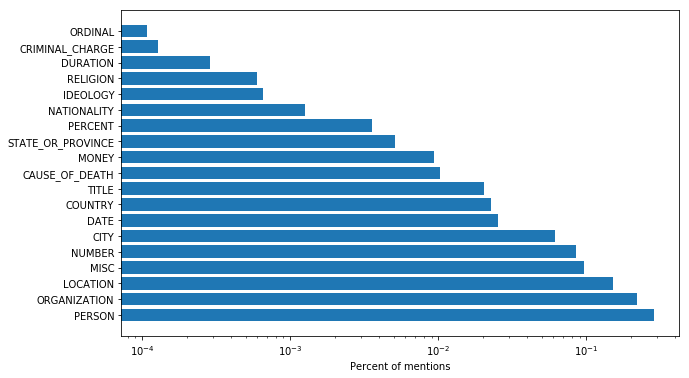

In [69]:
# bar chart pls
fb_data_es_ne_tag_counts = fb_data_es_ne_data.loc[:, 'tag'].value_counts()

fb_data_es_ne_tag_counts = fb_data_es_ne_tag_counts / fb_data_es_ne_tag_counts.sum()
Y = np.arange(fb_data_es_ne_tag_counts.shape[0])
plt.figure(figsize=(10, 6))
plt.barh(Y, fb_data_es_ne_tag_counts.values)
plt.yticks(Y, fb_data_es_ne_tag_counts.index)
plt.xscale('log')
plt.xlabel('Percent of mentions')
plt.show()

Does this mention distribution change over time?

In [13]:
fb_data_es_ne_data_list = []
for i, data_i in fb_data_es.iterrows():
    tags_i = data_i.loc['status_message_tags_ne']
    if(len(tags_i) > 0):
        names_i, tags_i = list(zip(*tags_i))
        ne_data_i = pd.DataFrame([names_i, tags_i], index=['name', 'type']).transpose()
        ne_data_i.loc[:, 'status_id'] = data_i.loc['status_id']
        fb_data_es_ne_data_list.append(ne_data_i)
fb_data_es_ne_full_data = pd.concat(fb_data_es_ne_data_list, axis=0)
## join with original data to obtain date 
fb_data_es_ne_full_data = pd.merge(fb_data_es_ne_full_data, fb_data_es.loc[:, ['status_id', 'status_published']], on='status_id')
print(fb_data_es_ne_full_data.shape)

(93431, 4)


In [14]:
# write to file
fb_data_es_ne_full_data.to_csv('../../data/facebook-maria/combined_group_data_es_ne.tsv', sep='\t', index=False)

,name,type,status_id,status_published
0,asma,CAUSE_OF_DEATH,351272391991842_362333787552369,2017-10-19 18:25:23
1,Dorado,ORGANIZATION,351272391991842_362333787552369,2017-10-19 18:25:23
2,Share,MISC,351272391991842_361695457616202,2017-10-18 06:47:34
3,general,TITLE,351272391991842_361695457616202,2017-10-18 06:47:34
4,Hipnoterapia Clínica Ericksoniana Sistémica,ORGANIZATION,351272391991842_361695457616202,2017-10-18 06:47:34


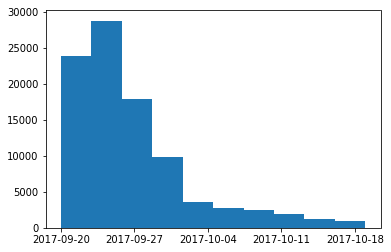

In [22]:
from datetime import datetime
display(fb_data_es_ne_full_data.head())
# discretize dates
def discretize_me_capn(x):
    x_date = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    x_date = datetime(year=x_date.year, month=x_date.month, day=x_date.day)
    return x_date
fb_data_es_ne_full_data.loc[:, 'status_published_day'] = fb_data_es_ne_full_data.loc[:, 'status_published'].apply(discretize_me_capn)
plt.hist(fb_data_es_ne_full_data.loc[:, 'status_published_day'].values)
plt.show()

Big flood of posts in the first few days, then tails off over time.

Let's see the daily distribution of NEs.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


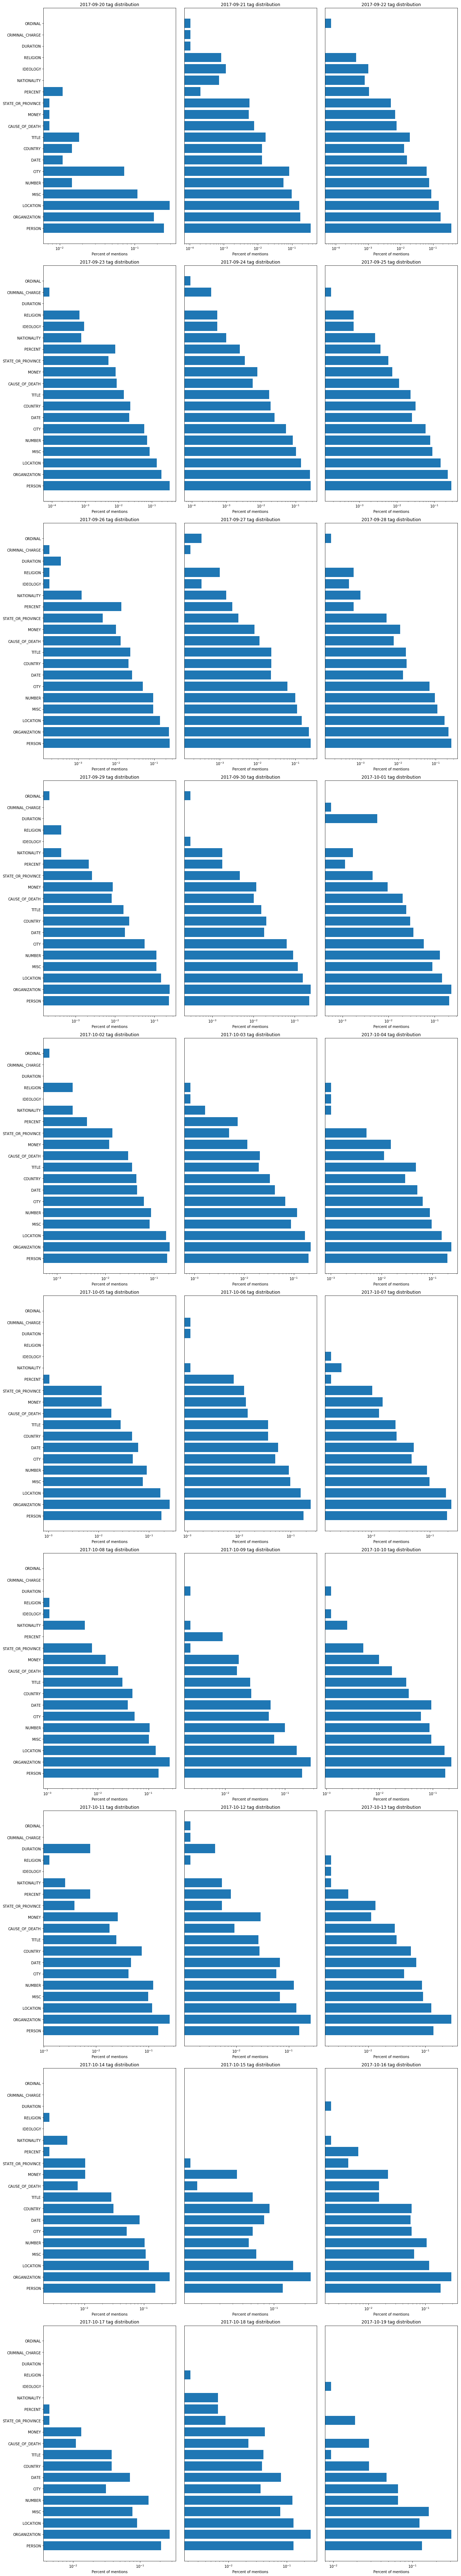

In [39]:
from math import ceil
all_tag_types = list(fb_data_es_ne_full_data.loc[:, 'type'].value_counts().index)
# print(all_tag_types)
Y = np.arange(len(all_tag_types))
cols = 3
rows = int(ceil(fb_data_es_ne_full_data.loc[:, 'status_published_day'].nunique() / cols))
fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*10))
for i, (date_i, data_i) in enumerate(fb_data_es_ne_full_data.groupby('status_published_day')):
    tag_type_counts = data_i.loc[:, 'type'].value_counts() / data_i.shape[0]
    # fill in zeros
    missing_tags = list(set(all_tag_types) - set(tag_type_counts.index))
    for t in missing_tags:
        tag_type_counts = tag_type_counts.set_value(t, 0)
    tag_type_counts = tag_type_counts.loc[all_tag_types]
    ax = axs[int(i / cols), i % cols]
    ax.barh(Y, tag_type_counts.values)
    if(i % cols == 0):
        ax.set_yticks(Y)
        ax.set_yticklabels(tag_type_counts.index)
    else:
        ax.set_yticks([])
    ax.set_xscale('log')
    ax.set_xlabel('Percent of mentions')
    ax.set_title('%s tag distribution'%(datetime.strftime(date_i, '%Y-%m-%d')))
plt.tight_layout()
plt.show()

- `LOCATION`, `ORGANIZATION`, `PERSON` dominate throughout
- this might look better as a line chart

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


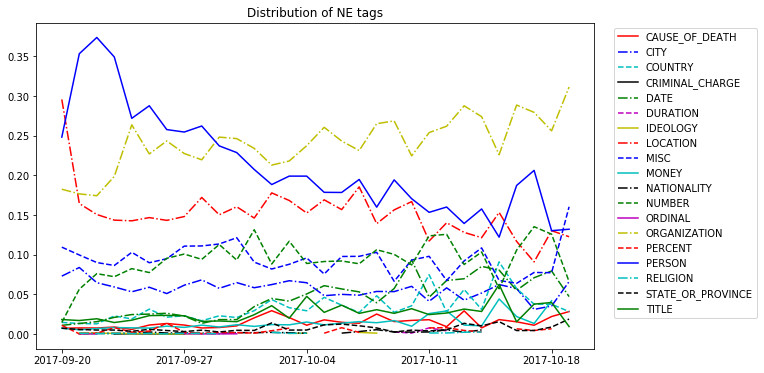

In [64]:
# make a line chart
colors = ['r', 'b', 'c', 'k', 'g', 'm', 'y']
linestyles = ['-', '-.', '--']
X = list(sorted(fb_data_es_ne_full_data.loc[:, 'status_published_day'].unique()))
date_counts = fb_data_es_ne_full_data.loc[:, 'status_published_day'].value_counts()
# print(date_counts)
plt.figure(figsize=(10, 6))
for i, (type_i, data_i) in enumerate(fb_data_es_ne_full_data.groupby('type')):
    tag_counts_i = data_i.groupby('status_published_day').apply(lambda x: x.shape[0] / date_counts.loc[x.loc[:, 'status_published_day'].iloc[0]])
    c_i = colors[i % len(colors)]
    l_i = linestyles[i % len(linestyles)]
    plt.plot(X, tag_counts_i.loc[X], c=c_i, linestyle=l_i, label=type_i)
# plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=[1.30, 1.])
plt.title('Distribution of NE tags')
plt.show()

- Decrease in `PERSON` (fewer mentions of "Maria")
- Increase in `ORGANIZATION` (more mentions of "FEMA"? relief organizations?)
- Slight increase in `COUNTRY` (calls for unity in "Puerto Rico"?)
- Slight increase in `TITLE` (appeals to "Governor"?)
- Slight decrease in `CITY` (less need for specific cities?)

## Tracking individual entities
Do individual entities show variation over time? Ex. `Dorado` gets more description over time.

In [140]:
!CLASSPATH=/hg190/corpora/StanfordCoreNLP/tmp/stanford-corenlp-full-2018-02-27/

In [158]:
import os
os.environ['CLASSPATH'] = "/hg190/corpora/StanfordCoreNLP/tmp/stanford-corenlp-full-2018-02-27/stanford-parser-full-2014-10-31/"
# try parsing an individual sentence
from nltk.parse.corenlp import CoreNLPParser
from nltk.parse.stanford import StanfordDependencyParser, StanfordParser
from nltk.tokenize import sent_tokenize
parser = CoreNLPParser(url='http://localhost:9003', tagtype='ner')
dep_parser = StanfordDependencyParser(path_to_jar='/hg190/corpora/StanfordCoreNLP/tmp/stanford-corenlp-full-2018-02-27/stanford-parser-full-2014-10-31/stanford-parser.jar',
                                      path_to_models_jar='/hg190/corpora/StanfordCoreNLP/tmp/stanford-corenlp-full-2018-02-27/stanford-spanish-corenlp-2018-02-27-models.jar')

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  if __name__ == '__main__':


In [203]:
sent_i_list = [list(parser.tokenize(s)) for s in sent_tokenize(fb_data_es.loc[:, 'status_message'].iloc[45])]
# sent_i = sent_i_list[1]
print(sent_i_list)
# sent_i_frag = ['Ella', 'vive', 'en', 'higuillar', 'en', 'Dorado']
# sent_i_frag = ['En', 'apoyo', 'a', 'el', 'alcalde', 'Carlos', 'Lopez', 'y', 'a', 'el', 'municipio', 'de', 'Dorado', 'Dorado', 'tiene', 'voz']
for sent_i in sent_i_list:
    # regular parse
    parse_i = next(parser.parse(sent_i))
    parse_i.pretty_print()
    # dependency parse
#     parse_i = next(dep_parser.parse(sent_i))
#     print(parse_i.to_conll(style=4))
# next(parser.parse(sent_i_frag)).pretty_print()

[['Tengo', 'amistades', 'en', 'Quintas', ',', 'Higuillar', ',', 'Santa', 'Rosa', 'y', 'Mameyal', '.'], ['¿', 'Alguien', 'sabe', 'cómo', 'están', 'las', 'cosas', '(', 'en', 'general', ')', 'en', 'esos', 'sectores', '?'], ['Aquellos', 'que', 'sepan', 'por', 'favor', 'escriban', '.'], ['¡', 'Vamo', "'", 'arriba', ',', 'Puerto', 'Rico', '!']]
                                      ROOT                                        
                                       |                                           
                                    sentence                                      
                                       |                                           
                                  interjeccio                                     
   ____________________________________|_______________________________________    
 VERB    NOUN   ADP  PROPN  PUNCT    PROPN    PUNCT PROPN PROPN CONJ  PROPN  PUNCT
  |       |      |     |      |        |        |     |     |    |      |  

In [185]:
test_sent = 'El número telefónico de Centro de Ayuda es el 123-456-7890.'
test_parse = next(parser.parse(parser.tokenize(test_sent)))
test_parse.pprint()
test_parse.pretty_print()
# print(next(dep_parser.parse(parser.tokenize(test_sent))).to_conll(style=4))

(ROOT
  (sentence
    (sn
      (grup.nom
        (DET El)
        (NOUN número)
        (ADJ telefónico)
        (ADP de)
        (PROPN Centro)
        (ADP de)
        (PROPN Ayuda)
        (VERB es)
        (DET el)
        (NOUN 123-456-7890)))
    (PUNCT .)))
                                     ROOT                                    
                                      |                                       
                                   sentence                                  
                              ________|___________________________________    
                             sn                                           |  
                             |                                            |   
                          grup.nom                                        |  
  ___________________________|__________________________________          |   
DET  NOUN     ADJ     ADP  PROPN     ADP    PROPN VERB DET     NOUN     PUNCT
 |    |        |       |    

In general it seems that the Stanford parsers (constituency and dependency!) are struggling even for basic sentences: 
- "El número telefónico de Centro de Ayuda y Servicio es el 407-895-0801." => `INTERJECTION`
- "En apoyo a el alcalde Carlos Lopez y a el municipio de Dorado Dorado tiene voz" => `NOM.GROUP`
- "Su hermano Tulio, hermana Vicky e familia no sabemos  de  el." => `INTERJECTION`
- "Hola alguien sabe para que es que FEMA va el sábado para Korea?" => `NOM.GROUP`
- "¿Alguien sabe cómo están las cosas (en general) en esos sectores?" => `NOM.GROUP`

Maybe the `spacy` parser will work better.

In [ ]:
## TODO: try spacy (we've seen that displacy works pretty well https://explosion.ai/demos/displacy)

Let's assume that a NE can occupy one of three positions of interest:

- head of NP ("Puerto Rico que es bonita")
- dependent of NP ("la isla de Puerto Rico")
- unattached ("Puerto Rico es bonita")

Do "new" entities fall into one position over another?

We should start by filtering all entities that occur more than X number of times.

In [ ]:
# filter 

## Track entity frequency, entropy over time
Maybe we're overthinking this. Let's take the top-k entities and track their relative frequency and contextual entropy over time.

$$H(e) = \sum_{i} H(e_{i} | w_{i-1},w_{i})$$

In [208]:
top_k = 50
# limit to likely locations: LOCATION and ORGANIZATION
top_k_entities = fb_data_es_ne_full_data[fb_data_es_ne_full_data.loc[:, 'type'].isin(['LOCATION', 'ORGANIZATION'])].loc[:, 'name'].apply(str.lower).value_counts().head(top_k)
display(top_k_entities)

pr                 1020
guayama             941
urb                 599
coamo               528
barranquitas        477
vega                463
quebradillas        400
yabucoa             354
cidra               310
fema                289
barrio              282
cayey               274
walmart             266
isla                241
utuado              201
carr                188
fam                 183
facebook            169
centro              155
ponce               149
corozal             146
lajas               143
patillas            137
aguadilla           127
bayamón             126
centro comunal      125
departamento        123
caguas              120
villa               115
familia             110
humacao              93
mayaguez             93
región               92
plaza                91
arroyo               90
arecibo              89
sebastián            88
eu                   80
iglesia              80
am                   80
llanos               79
fl              

The precision here is actually pretty good (only a few false positives like "facebook", "fam", "eu", "am").

In [209]:
fb_data_es_ne_full_data.head()

,name,type,status_id,status_published,status_published_day
0,asma,CAUSE_OF_DEATH,351272391991842_362333787552369,2017-10-19 18:25:23,2017-10-19
1,Dorado,ORGANIZATION,351272391991842_362333787552369,2017-10-19 18:25:23,2017-10-19
2,Share,MISC,351272391991842_361695457616202,2017-10-18 06:47:34,2017-10-18
3,general,TITLE,351272391991842_361695457616202,2017-10-18 06:47:34,2017-10-18
4,Hipnoterapia Clínica Ericksoniana Sistémica,ORGANIZATION,351272391991842_361695457616202,2017-10-18 06:47:34,2017-10-18


Possible metrics for entity "complexity":

- $P(\text{post}) = \prod_{i} P(w_{i} | w_{i-1}...)$
- $P(\text{context}) = \prod_{-K < i < K} P(w_{i} | w_{i-1}, w_{i+1})$

We can train an n-gram model (with backoff etc.) over each time-chunk to compute entropy for a word at a given point in time. We will have to test different cutoff (ex. cut data into 1/3, 1/4, depending on corpus size).

In [212]:
from nltk.probability import WittenBellProbDist
?WittenBellProbDist
freq_dist = (' '.join(fb_data_es.loc[:, 'status_message'].values)).split(' ')
test = WittenBellProbDist() 

In [266]:
from nltk.util import ngrams
from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize
from nltk.tokenize.casual import TweetTokenizer
from nltk import FreqDist, KneserNeyProbDist
from functools import reduce
import re

NUM_MATCHER = re.compile('[0-9\-]+')
URL_MATCHER = re.compile('https?://[^ ]+|www.[^ ]+')
def preproc(x):
    x = x.lower()
    x = NUM_MATCHER.sub('NUM', x)
    x = URL_MATCHER.sub('URL', x)
    return x
tokenizer = TweetTokenizer()
fb_data_es_sents = reduce(lambda x,y: x+y, fb_data_es.loc[:, 'status_message'].apply(sent_tokenize))
fb_data_es_ngrams = (ngram for sent in fb_data_es_sents for ngram in ngrams(tokenizer.tokenize(preproc(sent)), 3, pad_left = True, pad_right = True, right_pad_symbol='EOS', left_pad_symbol="BOS"))
# for i, ngram in enumerate(fb_data_es_ngrams):
#     print(ngram)
#     if(i > 5):
#         break
freq_dist = FreqDist(fb_data_es_ngrams)
kneser_ney = KneserNeyProbDist(freq_dist) # conditional probability

In [276]:
test_ngram_1 = ('ella', 'vive', 'en')
test_ngram_2 = ('tia', 'vive', 'en')
print(kneser_ney.prob(test_ngram_1))
print(kneser_ney.prob(test_ngram_2))

0.7548309178743962
0.08333333333333333


In [281]:
prob_sum = 0.
for i, samp in enumerate(kneser_ney.samples()):
#     if(i > 50):
#         print(samp)
#     if(i > 100):
#         break
    if(samp[0] == 'ella' and samp[1] == 'vive'):
        prob_i = kneser_ney.prob(trigram=samp)
        print('%s = %.3E'%(str(samp), prob_i))
        prob_sum += prob_i
print(prob_sum)

('ella', 'vive', 'en') = 7.548E-01
('ella', 'vive', '...') = 1.208E-03
('ella', 'vive', 'con') = 2.536E-02
('ella', 'vive', 'le') = 1.208E-03
('ella', 'vive', 'su') = 1.208E-03
('ella', 'vive', 'al') = 2.053E-02
('ella', 'vive', 'esta') = 1.208E-03
('ella', 'vive', 'sola') = 6.039E-03
('ella', 'vive', 'por') = 4.469E-02
('ella', 'vive', 'el') = 1.570E-02
('ella', 'vive', 'urb') = 1.208E-03
('ella', 'vive', 'detrás') = 1.087E-02
('ella', 'vive', 'serca') = 1.087E-02
('ella', 'vive', 'entre') = 1.208E-03
('ella', 'vive', 'y') = 1.208E-03
('ella', 'vive', 'frente') = 6.039E-03
('ella', 'vive', ',') = 1.208E-03
('ella', 'vive', 'la') = 1.208E-03
('ella', 'vive', 'eb') = 1.208E-03
('ella', 'vive', 'barrio') = 1.208E-03
('ella', 'vive', 'valles') = 1.208E-03
('ella', 'vive', 'mitad') = 1.208E-03
('ella', 'vive', 'detras') = 1.208E-03
('ella', 'vive', 'antes') = 1.208E-03
0.9130434782608697


In [272]:
for i, sent in enumerate(reduce(lambda x,y: x+y, fb_data_es.loc[:, 'status_message'].apply(sent_tokenize))):
    print(sent)
    if(i > 5):
        break

Estoy preocupada por mi tia vicky vazquez que desde el dia antes del huracan no se de ella pues ella es una mujer enferma tiene que usar oxijeno y ella me dijo el dia antes del huracan  que su oxijeno se avia acabado y que no se sentia bien pero que se estava dando terapias con la maquina del asma ella vive en higuillar en Dorado creo qye se llama arenar en la calle que vive al frente de su casa antes hera una vaqueria yo espero que ella este bien por favor si alguien del grupo es de esa aria y la conose digale que su sobrina la esta buscando gracias por favor de compartir
Para alguien que lo necesite... Dale Share..A todos nuestros amigos, pacientes y al publico en general;Hipnoterapia Clínica Ericksoniana Sistémica se une al esfuerzo de recuperación que todos vivimos en Puerto Rico y reanuda sus servicios de Hipnosis desde 10 de octubre del 2017.Durante los meses de Octubre/2017 y Noviembre/2017 estaremos ofreciendo servicios de recuperación por la crisis del Huracán María, con una o

Let's compute post-level entropy to start.

In [ ]:
from functools import reduce
from nltk.tokenize import sent_tokenize
from nltk.util import ngrams
from nltk.lm import Lidstone, MLE
from nltk.tokenize.casual import TweetTokenizer
import re
from nltk.stem import SnowballStemmer

## step 0: clean data
def mark_NE_in_status(tags, keep_tag_type=False):
    """
    Add NE tag to the end of all
    NEs in status
    """
    status_list = []
    curr_tag = ''
    curr_ne = []
    for word, tag in tags:
        if(tag != 'O'):
            if(curr_tag != '' and tag != curr_tag and len(curr_ne) > 0):
                curr_ne = ('_'.join([x for x,y in curr_ne]), curr_ne[0][1]) # save (word,tag)
                status_list.append(curr_ne)
                curr_ne = []
            curr_ne.append((word, tag))
        elif(tag != curr_tag and curr_tag != ''):
            curr_ne = ('_'.join([x for x,y in curr_ne]), curr_ne[0][1]) # save (word,tag)
            status_list.append(curr_ne)
            curr_ne = []
        if(tag == 'O'):
            status_list.append((word, tag))
        curr_tag = tag
    # catch any straggler NEs
    if(len(curr_ne) > 0):
        curr_ne = ('_'.join([x for x,y in curr_ne]), curr_ne[0][1]) # save (word,tag)
        status_list.append(curr_ne)
    if(keep_tag_type):
        status_word_list = ['%s.<%s>'%(word, tag) if tag != 'O' else word for word, tag in status_list]
    else:
        status_word_list = ['%s.<NE>'%(word) if tag != 'O' else word for word, tag in status_list]
    status_str = ' '.join(status_word_list)
    return status_str

NUM_MATCHER = re.compile('[0-9\-]+')
URL_MATCHER = re.compile('http://[ ^]+|www\.[^ ]+')
SPACE_MATCHER = re.compile('\s{2,}')
def process_status_tags(tags, stemmer=None):
    """
    Join NEs in status as single words,
    replace numbers/URLs with markers, and
    (optional) stem words.
    
    :param tags: (word, tag) list
    :param stemmer: optional SnowballStemmer
    :returns status_str: processed status
    """
    status_str = mark_NE_in_status(tags)
    status_str = NUM_MATCHER.sub(' NUM ', status_str)
    status_str = URL_MATCHER.sub(' URL ', status_str)
    status_str = SPACE_MATCHER.sub(' ', status_str)
    if(stemmer is not None):
        status_str = ' '.join([stemmer.stem(x) for x in status_str.split(' ')])
    return status_str

stemmer = SnowballStemmer('spanish')
fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'] = fb_data_es.loc[:, 'status_message_tags'].apply(lambda x: process_status_tags(x, stemmer))
display(fb_data_es.head())

## step 1: get full language model
def generate_ngrams(sent, tokenizer, n=3):
    return ngrams(tokenizer.tokenize(sent), n, pad_left = True, pad_right = True, right_pad_symbol='EOS', left_pad_symbol="BOS")
ngram_order = 3
tokenizer = TweetTokenizer()
fb_data_es_sents = reduce(lambda x,y: x+y, fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'].apply(sent_tokenize))
fb_data_es_ngrams = ((ngram for ngram in generate_ngrams(sent, tokenizer, n=ngram_order)) for sent in fb_data_es_sents)
# try training 
gamma = 0.1
fb_data_es_lm = Lidstone(order=ngram_order, gamma=gamma)
vocab = set(reduce(lambda x,y: x+y, [txt.split(' ') for txt in fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'].values]))
fb_data_es_lm.fit(fb_data_es_ngrams, vocabulary_text=vocab)

# step 2: compute entropy for each post
# per-sentence entropy takes FOREVER
fb_data_es.loc[:, 'status_message_entropy_%d'%(ngram_order)] = fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'].apply(lambda x: np.mean([fb_data_es_lm.entropy(generate_ngrams(sent, tokenizer, n=ngram_order)) for sent in sent_tokenize(x)]))
# sanity check for entropy
test_sents = fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'].iloc[:5]
for test_sent_i in test_sents:
    print('message = %s'%(test_sent_i))
    test_sent_i_ngrams = generate_ngrams(test_sent_i, tokenizer, n=ngram_order)
    entropy_i = fb_data_es_lm.entropy(test_sent_i_ngrams)
    print('entropy = %.3f'%(entropy_i))

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,"[(Estoy, O), (preocupada, O), (por, O), (mi, O...","[(asma, CAUSE_OF_DEATH), (Dorado, ORGANIZATION)]",estoy preocup por mi tia vicky vazquez que des...
1,351272391991842,10155877836122783,Para alguien que lo necesite... Dale Share..A ...,es,351272391991842_361695457616202,2017-10-18 06:47:34,"[(Para, O), (alguien, O), (que, O), (lo, O), (...","[(Share, MISC), (general, TITLE), (Hipnoterapi...",par algui que lo necesit ... da le share.<ne> ...
3,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,"[(En, O), (apoyo, O), (a, O), (el, O), (alcald...","[(alcalde, TITLE), (Carlos Lopez, PERSON), (Do...",en apoy a el alcalde.<ne> carlos_lopez.<ne> y ...
4,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,"[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...","[(Puerto Rico, COUNTRY), (America, MISC), (Pue...",puebl de puerto_rico.<ne> no se mont en las gr...
5,351272391991842,141039043205101,PUEBLO DE PUERTO RICO no esperan ninguna ayuda...,es,351272391991842_358942134558201,2017-10-11 14:37:12,"[(PUEBLO, O), (DE, O), (PUERTO, O), (RICO, O),...","[(Estados Unidos, COUNTRY), (Puerto Rico, COUN...",puebl de puert ric no esper ningun ayud federa...


In [465]:
# save to file to avoid crashes!!
fb_data_es.to_csv('../../data/facebook-maria/combined_group_data_es_ne_entropy.tsv', sep='\t', index=False)

In [21]:
import pandas as pd
from ast import literal_eval
fb_data_es = pd.read_csv('../../data/facebook-maria/combined_group_data_es_ne_entropy.tsv', sep='\t', index_col=False, converters={1:literal_eval})
# remove nans
fb_data_es = fb_data_es[~ fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'].apply(lambda x: np.isnan(x) if type(x) is not str else False)]
# convert string => list
fb_data_es.loc[:, 'status_message_tags'] = fb_data_es.loc[:, 'status_message_tags'].apply(literal_eval)
fb_data_es.loc[:, 'status_message_tags_ne'] = fb_data_es.loc[:, 'status_message_tags_ne'].apply(literal_eval)
display(fb_data_es.head())

,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed,status_message_entropy_3,time_period
0,130913387550000,10159568931595523,Saludos: han tenido comunicación con alguien e...,es,130913387550000_130915504216455,2017-09-20 16:16:41,"[(Saludos, O), (:, O), (han, O), (tenido, O), ...","[(Yabucoa, LOCATION), (Jardines, MISC)]",salud : han ten comun con algui en yabucoa.<ne...,5.673383,1
1,130913387550000,10155582232762110,Gente vamos a ver si podemos usar esto para el...,es,130913387550000_130915764216429,2017-09-20 16:18:04,"[(Gente, O), (vamos, O), (a, O), (ver, O), (si...","[(Yabucoa, LOCATION)]",gent vam a ver si pod usar esto par el benefic...,7.614204,1
2,130913387550000,10155707961212557,Le postearon esto al hermano de Heriberto está...,es,130913387550000_130915814216424,2017-09-20 16:18:07,"[(Le, O), (postearon, O), (esto, O), (a, O), (...","[(Heriberto, PERSON), (Juncos, MISC), (Yabucoa...",le post esto a el herman de heriberto.<ne> est...,8.443579,1
3,130913387550000,1865472563470689,Buenas hablo desde Boston Massachusetts. Quisi...,es,130913387550000_130916214216384,2017-09-20 16:22:18,"[(Buenas, O), (hablo, O), (desde, O), (Boston,...","[(Boston, LOCATION), (Massachusetts, STATE_OR_...",buen habl desd boston.<ne> massachusetts.<ne> ...,5.850905,1
4,130913387550000,10155667303410915,en Wapa acaban de decir que en unos minutos te...,es,130913387550000_130917210882951,2017-09-20 16:29:17,"[(en, O), (Wapa, LOCATION), (acaban, O), (de, ...","[(Wapa, LOCATION), (Yabucoa, LOCATION)]",en wapa.<ne> acab de dec que en unos minut ten...,7.647296,1


Test 1: does per-post entropy stay stable over time?

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


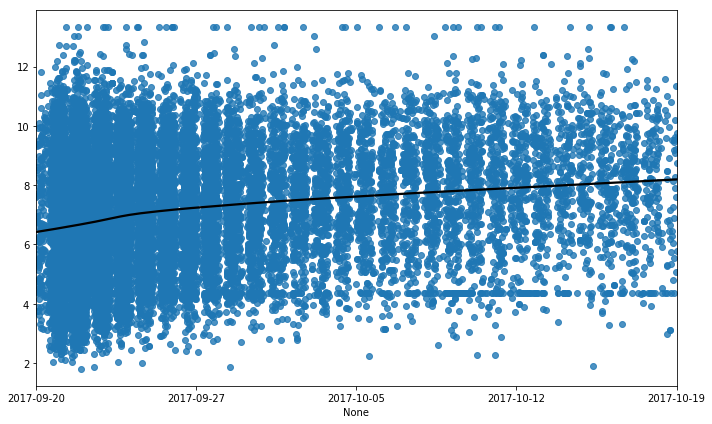

In [3]:
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
fb_data_es_valid_entropy = fb_data_es[~ np.isnan(fb_data_es.loc[:, 'status_message_entropy_3'])]
if(type(fb_data_es_valid_entropy.loc[:, 'status_published'].iloc[0]) is str):
    fb_data_es_valid_entropy.loc[:, 'status_published'] = fb_data_es_valid_entropy.loc[:, 'status_published'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
x, y = zip(*fb_data_es_valid_entropy.loc[:, ['status_published', 'status_message_entropy_3']].values)
x_num = pd.Series(x).apply(lambda x: x.timestamp())
y = np.array(y)
plt.figure(figsize=(10, 6))
sns.regplot(x_num, y, lowess=True, line_kws={'color':'k'})
# plt.scatter(x_num, y, c='k', alpha=0.1)
plt.xlim(x_num.min(), x_num.max())
## custom ticks
x_tick_count = 5
xticks = np.linspace(x_num.min(), x_num.max(), x_tick_count)
xtick_labels = [datetime.strftime(datetime.fromtimestamp(ts), '%Y-%m-%d') for ts in xticks]
plt.xticks(xticks, xtick_labels)
plt.tight_layout()
plt.show()

Slight increase in entropy over time, which makes sense given the distribution: the language model gets most of the probability from the early period, which means that the late period is less predictable and thus higher probability.

What is that flat line of entropy toward the bottom? Could be something highly predictable like a one-word message repeated.

In [367]:
display(fb_data_es_valid_entropy[fb_data_es_valid_entropy.loc[:, 'status_message_entropy_3']==fb_data_es_valid_entropy.loc[:, 'status_message_entropy_3'].mode()[0]].head())

,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed,status_message_entropy_3
57,351272391991842,1530944146999765,https://www.metro.pr/pr/noticias/2017/09/23/es...,es,351272391991842_352173238568424,2017-09-24 03:19:05,[(https://www.metro.pr/pr/noticias/2017/09/23/...,[],https://url,4.372203
58,351272391991842,1530944146999765,https://www.metro.pr/pr/noticias/2017/09/23/ba...,es,351272391991842_352173045235110,2017-09-24 03:18:00,[(https://www.metro.pr/pr/noticias/2017/09/23/...,[],https://url,4.372203
59,351272391991842,1530944146999765,https://www.metro.pr/pr/noticias/2017/09/23/pa...,es,351272391991842_352172408568507,2017-09-24 03:14:19,[(https://www.metro.pr/pr/noticias/2017/09/23/...,[],https://url,4.372203
68,351272391991842,1793344337361069,https://www.yahoo.com/finance/news/powerless-p...,es,351272391991842_352043208581427,2017-09-23 17:47:51,[(https://www.yahoo.com/finance/news/powerless...,[],https://url,4.372203
82,351272391991842,1530944146999765,https://www.elnuevodia.com/noticias/locales/no...,es,351272391991842_351736478612100,2017-09-23 01:09:08,[(https://www.elnuevodia.com/noticias/locales/...,[],https://url,4.372203


Correct! Those low-entropy posts are just single-URL posts. We should have removed those earlier.

Next test: do entities start with high information status and later reach lower information status?

Easiest way to do this is probably to make a DTM with all NEs and words for cols, status number for rows, then aggregate by time.

['puerto_rico.ne', 'pr.ne', 'guayama.ne', 'urb.ne', 'coamo.ne', 'barranquitas.ne', 'vega.ne', 'quebradillas.ne', 'yabucoa.ne', 'alta.ne', 'cidra.ne', 'fema.ne', 'barrio.ne', 'corozal.ne', 'san.ne', 'cayey.ne', 'san_juan.ne', 'walmart.ne', 'isla.ne', 'baja.ne', 'utuado.ne', 'carr.ne', 'fam.ne', 'facebook.ne', 'estados_unidos.ne', 'centro.ne', 'ponce.ne', 'lajas.ne', 'patillas.ne', 'aguadilla.ne']


.           0.641781
,           0.414845
sab         0.106147
algui       0.100673
num.<ne>    0.099044
viv         0.081147
tod         0.078398
bien        0.077811
ayud        0.077157
...         0.077149
tien        0.074695
pued        0.065615
per         0.065467
com         0.063932
graci       0.061828
!           0.059585
dia         0.056200
estan       0.055803
llam        0.054891
famili      0.052829
dtype: float64

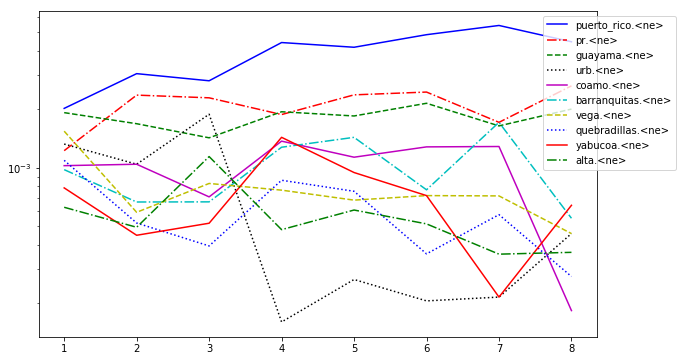

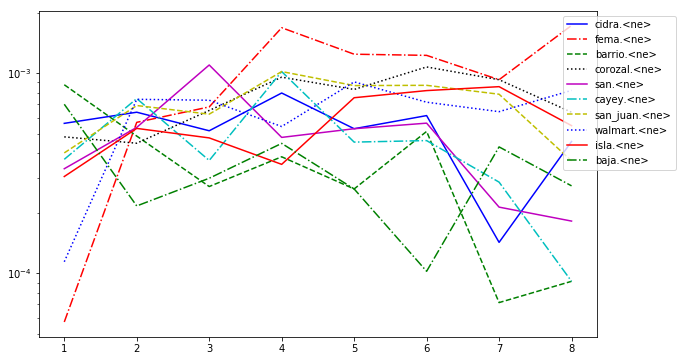

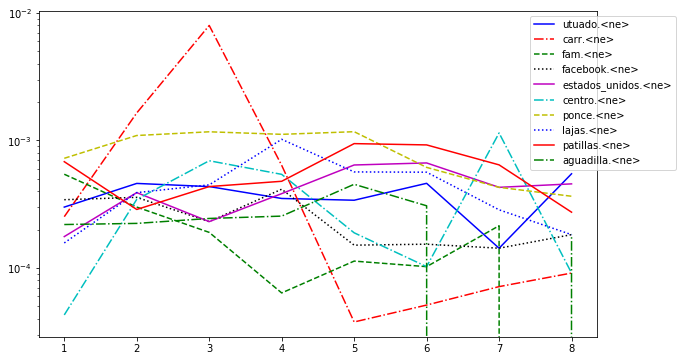

In [68]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode
from functools import reduce
from datetime import datetime
from math import ceil

## compute DTM
fb_data_es.sort_values('status_published', ascending=True, inplace=True)
stop_words = stopwords.words('spanish') + ['favor', 'ne', 'num', 'par', 'si']
cv = CountVectorizer(min_df=5, ngram_range=(1,1), stop_words=stop_words, tokenizer=lambda x: x.split(' '))
sents = fb_data_es.loc[:, 'status_message_ne_tagged_stemmed'].values
fb_data_es_dtm = cv.fit_transform(sents)
fb_data_es_dtm_idx_to_vocab = {v:k for k,v in cv.vocabulary_.items()}

## track top-20 location entities
fb_data_es_entities = pd.Series(reduce(lambda x,y: x+y, fb_data_es.loc[:, 'status_message_tags_ne'].values))
loc_entity_types = ['LOCATION', 'ORGANIZATION', 'CITY', 'COUNTRY']
fb_data_es_entities = fb_data_es_entities[fb_data_es_entities.apply(lambda x: x[1] in loc_entity_types)].apply(lambda x: x[0].lower().replace(' ', '_')+'.ne')
top_k = 30
# display(fb_data_es_entities.value_counts().head(top_k))
top_k_entities = fb_data_es_entities.value_counts().head(top_k).index.tolist()
print(top_k_entities)

## split by time
time_period_count = 9
if(type(fb_data_es.loc[:, 'status_published'].iloc[0]) is str):
    fb_data_es.loc[:, 'status_published'] = fb_data_es.loc[:, 'status_published'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
fb_data_es_timestamps = fb_data_es.loc[:, 'status_published'].apply(lambda x: x.timestamp())
fb_data_es.loc[:, 'time_period'] = np.digitize(fb_data_es_timestamps, bins=np.linspace(fb_data_es_timestamps.min(), fb_data_es_timestamps.max(), time_period_count))
# collapse dtm, normalize freq
dtm_vocab = [fb_data_es_dtm_idx_to_vocab[i] for i in np.arange(len(fb_data_es_dtm_idx_to_vocab))]
dtm_time = []
for i in sorted(fb_data_es.loc[:, 'time_period'].unique()):
    dtm_i = np.array(fb_data_es_dtm[np.where(fb_data_es.loc[:, 'time_period']==i)].sum(axis=0))[0]
    dtm_i = dtm_i / dtm_i.sum() # normalize
    dtm_i = pd.Series(dtm_i, index=dtm_vocab)
    dtm_time.append(dtm_i)
dtm_time = pd.concat(dtm_time, axis=1).transpose()
# sanity check: do top words make sense?
display(dtm_time.sum(axis=0).sort_values(inplace=False, ascending=False)[:20])
# yes! "alguien", "saber", etc.

## plot top entities
time_periods = np.arange(1, time_period_count) # last time period is buggy
chunk_size = 10
chunks = int(ceil(top_k / chunk_size))
colors = ['b', 'r', 'g', 'k', 'm', 'c', 'y']
linestyles = ['-', '-.', '--', ':']
for top_j_entities in np.split(np.array(top_k_entities), chunks):
    plt.figure(figsize=(10, 6))
    for i, entity_i in enumerate(top_j_entities):
        entity_i = unidecode(entity_i.replace('ne', '<ne>'))
        color_i = colors[i % len(colors)]
        linestyle_i = linestyles[i % len(linestyles)]
        plt.plot(time_periods, dtm_time.loc[:, entity_i].iloc[:-1], label=entity_i, c=color_i, linestyle=linestyle_i)
    plt.yscale('log')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.))
    plt.show()

## compute mean entropy/char length for all statuses containing entity - WHEW
# first: build entity data-frame
# fb_data_es_entity_data = fb_data_es.loc[:, ['status_published', 'status_message_tags_ne', 'status_message_entropy_3', 'status_message']]
# # add entity dtm cols for filtering
# top_k_entity_idx = [cv.vocabulary_[e] for e in top_k_entities]
# top_k_entity_dtm = pd.DataFrame(fb_data_es_dtm[:, top_k_entity_idx], index=fb_data_es_entity_data.index, columns=top_k_entities)
# fb_data_es_entity_data = pd.concat([fb_data_es_entity_data, top_k_entity_dtm], axis=1)
# display(fb_data_es_entity_data.head())
# ## split by time: 
# time_chunks = 4

Overall pretty steady trends for most NEs.

What about NEs that show consistent growth? I.e. not mentioned in the first quarter but then adopted afterward. We can see if they start off with excess descriptors and eventually reach "hearer-old".

Simple model: entropy ~ age

Model design: entropy ~ age + absolute_time + random-effect(word) + error

In [69]:
late_idx = (dtm_time.iloc[0, :]==0)
late_idx = late_idx[late_idx].index.tolist()
late_entities_idx = list(filter(lambda x: '<ne>' in x, late_idx))
display(dtm_time.loc[:, late_entities_idx[20:50]].head())
print('%d late entities'%(len(late_entities_idx)))
print('\n'.join(sorted(late_entities_idx)))

,aqui.<ne>,aquilino_cabanmaricao.<ne>,area_guzman.<ne>,aths.<ne>,autoridad.<ne>,ave._num_inf.<ne>,bauta_centroyauco_num_camion_cisterna.<ne>,bellas_arteshumacao.<ne>,blanca.<ne>,brisas_i.<ne>,...,canena_marquezmoca.<ne>,cantante.<ne>,cantera_taxi_esta.<ne>,capilla_catolicacaguas.<ne>,capilla_catolicacaguas_num_bo.<ne>,caritemaunabo_num_camion.<ne>,carlos_lopez.<ne>,carlos_miguel.<ne>,carraizocarolina.<ne>,carraizotrujillo_alto.<ne>
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000006,0.000070,0.000096,0.000070,0.000032,0.000070,0.000064,0.000064,0.000013,0.000096,...,0.000089,0.000006,0.000000,0.000096,0.000064,0.000064,0.000019,0.000019,0.000089,0.000064
2,0.000014,0.000068,0.000516,0.000014,0.000014,0.000054,0.000054,0.000027,0.000041,0.000530,...,0.000516,0.000000,0.000000,0.000530,0.000027,0.000054,0.000027,0.000027,0.000516,0.000027
3,0.000032,0.000000,0.000032,0.000000,0.000032,0.000000,0.000000,0.000000,0.000000,0.000032,...,0.000032,0.000032,0.000000,0.000032,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000038,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000113,0.000226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


316 late entities
$_num,num.<ne>
.num.<ne>
a.m..<ne>
abrojos.<ne>
acad.<ne>
aguirre.<ne>
aida_crespo.<ne>
aisladascaguas_num_borinquen_atravesada.<ne>
alcaldiacorozal.<ne>
alcaldiamanati_num_manejo_emergenciavega_alta_num_manejo_emergencia.<ne>
alcapurria_quema.<ne>
alcarde.<ne>
aldis.<ne>
alimentos_/_suministros.<ne>
alto_num_calle_jose.<ne>
alto_num_centro_comercial.<ne>
amarylis_rosado.<ne>
angelica.<ne>
anibal_reyesoasis_region.<ne>
april_gardens.<ne>
aqui.<ne>
aquilino_cabanmaricao.<ne>
area_guzman.<ne>
aths.<ne>
autoridad.<ne>
ave._num_inf.<ne>
bauta_centroyauco_num_camion_cisterna.<ne>
bellas_arteshumacao.<ne>
blanca.<ne>
brisas_i.<ne>
burritoceiba_num_detras_cancha.<ne>
caimitosan_juan_num_carr.<ne>
calle_jose.<ne>
camiones.<ne>
campo_ricocanovanas_num_carr.<ne>
camuymorovis_num_hospital_cdt_morovis_community_heart_centerquebradillas_num_sector_guajataca.<ne>
cancha_bajo_techo.<ne>
cancha_bajo_techomoca_num_pr.<ne>
cancha_gelito_ortega.<ne>
candelero_abajo.<ne>
canena_marquezmo

OK! Not a great turnout but we'll take what we can get. 

Let's run a correlation between entity age and contextual entropy. We'll mark each entity's age as the time since its first mention.

In [165]:
from nltk.tokenize import sent_tokenize
fb_data_es_entity_age = fb_data_es.loc[:, ['status_id', 'status_published', 'status_message_entropy_3', 'status_message_ne_tagged_stemmed']].copy()
entity_age_data = []
for entity_i in late_entities_idx:
    entity_i_idx = cv.vocabulary_[entity_i]
    fb_data_es_dtm_i_idx = np.where((fb_data_es_dtm[:, entity_i_idx]>0.).todense())[0]
    fb_data_es_entity_age_i = fb_data_es_entity_age.iloc[fb_data_es_dtm_i_idx, :]
    entity_i_birth_date = fb_data_es_entity_age_i.loc[:, 'status_published'].min()
    entity_i_age = np.array(list(map(lambda x: float(x), list((fb_data_es_entity_age.iloc[fb_data_es_dtm_i_idx, :].loc[:, 'status_published'] - entity_i_birth_date).values))))
    entity_i_sents = fb_data_es_entity_age_i.loc[:, 'status_message_ne_tagged_stemmed'].apply(lambda x: len(sent_tokenize(x))).values
    entity_i_words = fb_data_es_entity_age_i.loc[:, 'status_message_ne_tagged_stemmed'].apply(lambda x: np.mean(list(map(lambda x: len(x.split(' ')), sent_tokenize(x))))).values
    entity_i_entropy = fb_data_es_entity_age_i.loc[:, 'status_message_entropy_3'].values
    entity_i_entropy_sent_norm = entity_i_entropy / entity_i_sents
    entity_i_entropy_word_norm = entity_i_entropy / entity_i_words
    entity_i_date = fb_data_es_entity_age_i.loc[:, 'status_published'].apply(lambda x: float(x.timestamp())).values
    entity_i_id = fb_data_es_entity_age_i.loc[:, 'status_id'].values
    entity_i_data = pd.DataFrame([entity_i_age, entity_i_entropy, entity_i_entropy_sent_norm, entity_i_entropy_word_norm, entity_i_sents, entity_i_words, entity_i_date, entity_i_id], 
                                 index=['age', 'entropy', 'entropy_sent_norm', 'entropy_word_norm', 'post_length', 'sent_length', 'time', 'status_id']).transpose()
    entity_i_data.loc[:, 'entity'] = entity_i
    entity_age_data.append(entity_i_data)
entity_age_data = pd.concat(entity_age_data, axis=0)
# recast float cols
entity_age_attrs = ['age', 'entropy', 'entropy_sent_norm', 'entropy_word_norm', 'sent_length', 'post_length', 'time']
for a in entity_age_attrs:
    entity_age_data.loc[:, a] = entity_age_data.loc[:, a].astype(float)
display(entity_age_data.head())

,age,entropy,entropy_sent_norm,entropy_word_norm,post_length,sent_length,time,status_id,entity
0,0.000000e+00,8.259277,4.129639,0.284803,2.0,29.000000,1.506342e+09,127217134598253_129950327658267,"$_num,num.<ne>"
1,7.453000e+12,7.970581,1.328430,0.274848,6.0,29.000000,1.506350e+09,889808494515226_891618314334244,"$_num,num.<ne>"
2,9.112200e+13,8.751599,0.397800,0.283140,22.0,30.909091,1.506433e+09,132392547395104_134943907139968,"$_num,num.<ne>"
3,1.056230e+14,8.718208,0.348728,0.296942,25.0,29.360000,1.506448e+09,119132632075224_120133571975130,"$_num,num.<ne>"
4,2.745400e+14,9.100972,1.820194,0.344734,5.0,26.400000,1.506617e+09,228066954387757_232000513994401,"$_num,num.<ne>"


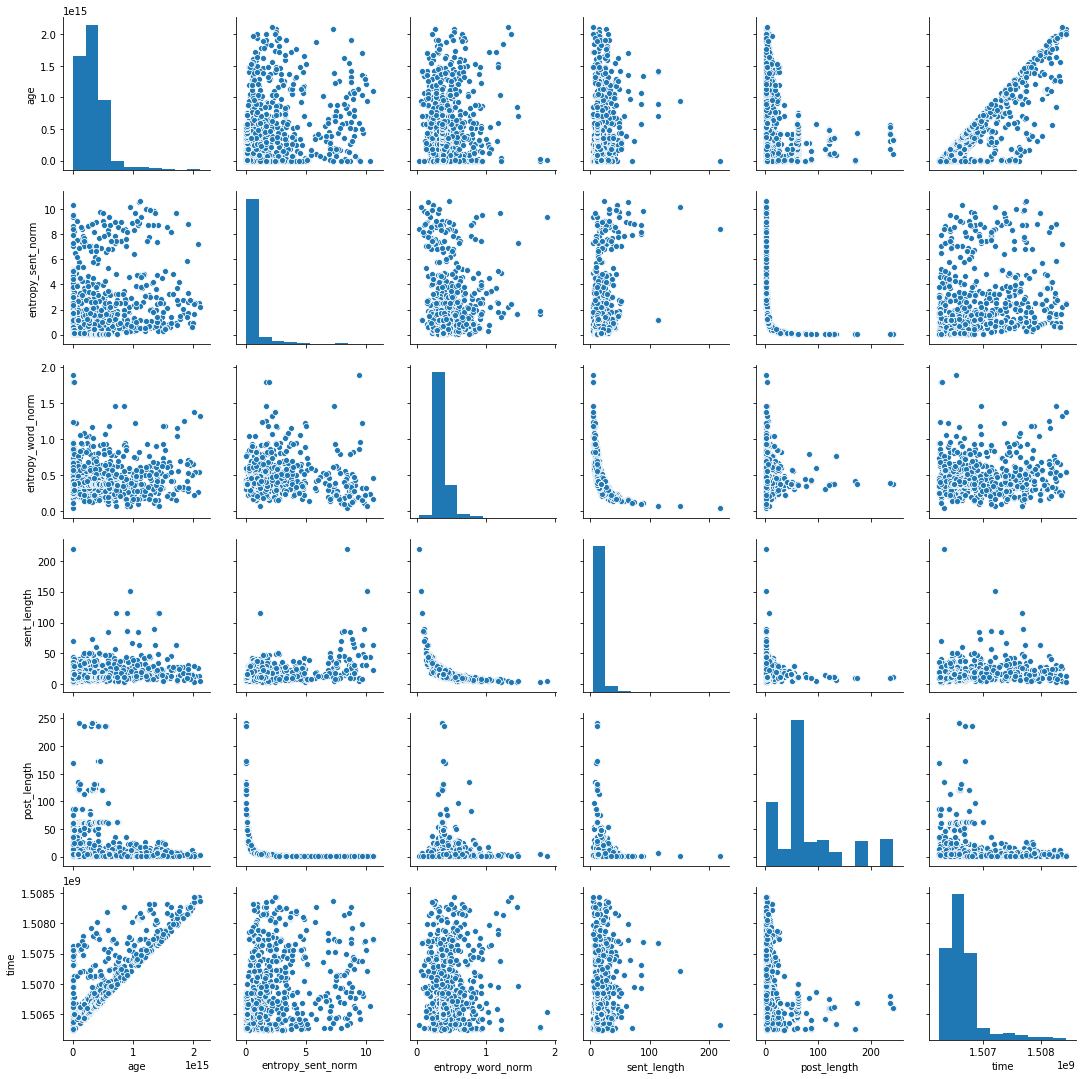

In [166]:
import seaborn as sns
entity_age_attrs = ['age', 'entropy_sent_norm', 'entropy_word_norm', 'sent_length', 'post_length', 'time']
sns.pairplot(entity_age_data.loc[:, entity_age_attrs])
plt.show()

In [174]:
from statsmodels.formula.api import OLS
from sklearn.preprocessing import StandardScaler
# Z-norm etc.
scaler = StandardScaler()
entity_age_data_norm = entity_age_data.copy()
scalar_col_names = ['entropy_sent_norm', 'entropy_word_norm', 'post_length', 'sent_length', 'age', 'time']
entity_age_data_norm = pd.DataFrame(scaler.fit_transform(entity_age_data_norm.loc[:, scalar_col_names]), columns=scalar_col_names)
for y_i, x_i in zip(['entropy_sent_norm', 'entropy_word_norm'], ['post_length', 'sent_length']):
    ols_model = OLS(entity_age_data_norm.loc[:, y_i], entity_age_data_norm.loc[:, ['age', 'time',  x_i]])
    results = ols_model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      entropy_sent_norm   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     562.3
Date:                Sun, 20 Jan 2019   Prob (F-statistic):          1.60e-315
Time:                        18:11:44   Log-Likelihood:                -6472.5
No. Observations:                5075   AIC:                         1.295e+04
Df Residuals:                    5072   BIC:                         1.297e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
age            -0.0755      0.021     -3.528      

OK! This shows that:
- longer age => lower entropy (makes sense! more given information)
- longer time => more entopy (more common ground => more new information)
- longer post/sent length => lower entropy (more repetitive language? sure)

Let's visualize the age/entropy relationship by normalizing entity age to [0,1].

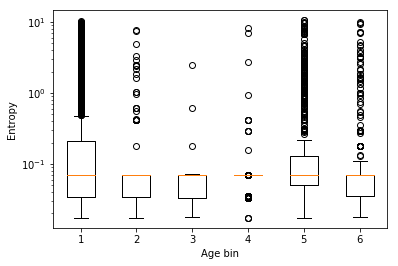

In [175]:
entity_age_data_norm_age = entity_age_data.groupby('entity').apply(lambda x: (x.loc[:, 'age'] - x.loc[:, 'age'].min()) / (x.loc[:, 'age'].max() - x.loc[:, 'age'].min()))
entity_age_data_norm_age = entity_age_data_norm_age.reset_index().rename(columns={'age':'age_norm'}).drop('level_1', axis=1)
entity_age_data.loc[:, 'age_norm'] = entity_age_data_norm_age.loc[:, 'age_norm']
# sns.regplot(entity_age_data.loc[:, 'age_norm'], entity_age_data.loc[:, 'entropy'])
# sns.lineplot(x='age_norm', y='entropy', data=entity_age_data)
# scatter/line plot is too messy! need more aggregation
# maybe a binned plot would look better
age_bins = 6
entity_age_data.loc[:, 'age_norm_bin'] = np.digitize(entity_age_data.loc[:, 'age_norm'], np.linspace(0, 1., age_bins))
entity_age_data_bins = entity_age_data.groupby('age_norm_bin').apply(lambda x: x.loc[:, 'entropy_sent_norm'].values)
# entity_age_data_bins = [entity_age_data_bins.loc[i].reset_index().loc[:, 'entropy'].values for i in entity_age_data_bins.index]
plt.boxplot(entity_age_data_bins)
plt.xlabel('Age bin')
plt.ylabel('Entropy')
plt.yscale('log')
plt.show()

Pretty minimal variation overall except at end-points (higher variance).

Maybe we need to stratify by time.

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


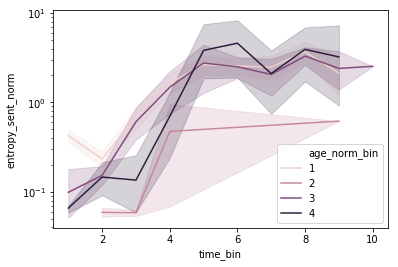

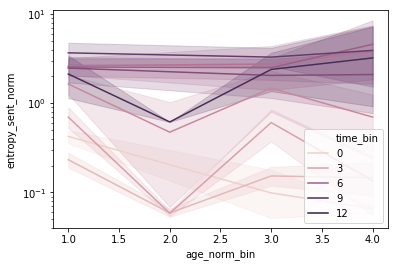

In [179]:
age_bins = 4
entity_age_data.loc[:, 'age_norm_bin'] = np.digitize(entity_age_data.loc[:, 'age_norm'], np.linspace(0, 1., age_bins))
time_period_count = 10
entity_age_data.loc[:, 'time_bin'] = np.digitize(entity_age_data.loc[:, 'time'], np.linspace(entity_age_data.loc[:, 'time'].min(), entity_age_data.loc[:, 'time'].max(), time_period_count))
## time vs. entropy
## hard to see but younger ages tend to have higher entropy at first
sns.lineplot(x='time_bin', y='entropy_sent_norm', hue='age_norm_bin', data=entity_age_data)
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()
## age vs. entropy
sns.lineplot(x='age_norm_bin', y='entropy_sent_norm', hue='time_bin', data=entity_age_data)
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

It looks like the "aging" effect is more pronounced for the entities generated at the beginning of time. Could be due to data sparsity among later entities!

What are some examples of low-entropy and high-entropy contexts?

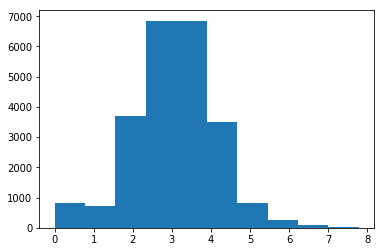

1. GENTE EN 🇵🇷🇵🇷🇵🇷 Pongalo en sus status para que su familia sepa donde buscar provisiones!Bayamón – Carr. 829, entrada a Collores, Urb. Santa OlayaBayamón – Ave. Santa Juanita, Esquina Hostos, frente Funeraria AsencioBayamón – Al final Ave. Irlanda Height, calle Palestina, Santa JuanitaTrujillo Alto – Carolina y ese es el shopping center donde está Walmart.Trujillo Alto – PR 843, Km 3.5 frente a Urb. Villas de CarraízoCarolina – Carr. 845, Ave. Montecarlo, frente a Portal de la ReinaGuaynabo – Carr. 833, Int. Centros de Servicios Múltiples GuaraguaoGuaynabo – Expreso 852 final, en el estacionamiento La Ceiba, GuaynaboSan Juan – Ave. Víctor Labiosa, carr. 176 frente a St. Marys SchoolSan Juan – Estadio Hiram BithornSan Juan – Marginal Exp. PR 52, Esquina Calle Popy, frente Urb. VilanovaSan Juan – Carr. PR 842, Esquina Camino Los Romero, CaimitoSan Juan – Carr. 176, Esquina Camino Morcelo, Frente a la iglesiaSan Juan – Centro Comercial Los Flamboyanes, Ave. 65 Inf. Al lado de la Mazda d

In [221]:
tmp = fb_data_es.copy()
tmp.loc[:, 'status_message_len'] = tmp.loc[:, 'status_message'].apply(lambda x: np.log(len(x.split(' '))))
plt.hist(tmp.loc[:, 'status_message_len'].values)
plt.show()
tmp.sort_values('status_message_len', inplace=True, ascending=False)
print('\n'.join(['%d. %s'%(i+1, x) for i, x in enumerate(tmp.loc[:, 'status_message'].head(20).values)]))

In [210]:
import re
test_matcher = re.compile('cancha bajo techo')
for x in fb_data_es[fb_data_es.loc[:, 'status_message'].apply(lambda x: test_matcher.search(x.lower()) is not None)].loc[:, 'status_message'].head():
    print(x)

Llama!!!787 864 3875 Refugio en Olimpo 787 864 0600 Refugio de la Cancha Bajo techo de Guayama
Soy de guayabota me gustaría saber de Migdalia Laureano y Keylianis viven al lado de la cancha bajo techo..... María Melendez de guayaboa sector el 20.........  De la Familia  Navarro en Jacanas granjas
Estoy buscando información de mi familia José Ortiz (Mandolina) que vive un bloqueo más arriba de la cancha bajo techo pasando el supermercado plaza. Por favor que son la única familia que no a escuchado noticia.
Listado de los oasis ubicados alrededor de la Isla:•Región Metro:Bayamón - Carr. PR 829 entrada a Collores, Santa OlayaBayamón - Avenida Santa Juanita, Esquina Hostos Frente Funeraria AsencioCanóvanas - Carr. PR 185, Alturas de Campo RicoCanóvanas - Carr. PR 962, sector CambalacheTrujillo Alto - Calle José de Diego, Centro Comercial Escorial, detrás de Home DepotTrujillo Alto - PR-843, Km 3.5 frente a Urb. Villas de CarraízoTrujillo Alto - Frente al Parque de Pelota, carr. PR 851, sec

In [198]:
low_entropy_cutoff_pct = 25.
high_entropy_cutoff_pct = 75.
entropy_attr = 'entropy_sent_norm'
sample_entities = ['calle_jose.<ne>', 'cancha_bajo_techo.<ne>', 'carraizotrujillo_alto.<ne>', 'castro_iaguas_buenas.<ne>', 'ceiba_arriba.<ne>', 'coliseo_municipal.<ne>', 'demetrio_rivera.<ne>', 'emajaguas.<ne>', 'escuela_rosa_bernardi.<ne>', 'esquina_calle_popy.<ne>', 'escuela_padre_anibal_reyescorozal.<ne>', 'garden_hills.<ne>', 'municipio_autonomo.<ne>', 'santa_juanita.<ne>', 'universidad_pontificia.<ne>', 'viajes.<ne>']
for entity_i in sample_entities:
    print('testing entity %s'%(entity_i))
    entity_age_data_i = entity_age_data[entity_age_data.loc[:, 'entity']==entity_i]
    entity_age_data_i = pd.merge(entity_age_data_i, fb_data_es.loc[:, ['status_id', 'status_message_ne_tagged_stemmed']], on='status_id')
    entity_age_data_i.sort_values(entropy_attr, inplace=True, ascending=False)
    ## get low entropy, high entropy bins
    # data sparsity!! no good
#     entity_age_data_i_low_entropy = entity_age_data_i[entity_age_data_i.loc[:, entropy_attr] < np.percentile(entity_age_data_i.loc[:, entropy_attr], low_entropy_cutoff_pct)]
#     entity_age_data_i_high_entropy = entity_age_data_i[entity_age_data_i.loc[:, entropy_attr] > np.percentile(entity_age_data_i.loc[:, entropy_attr], high_entropy_cutoff_pct)]
#     print(entity_age_data_i_low_entropy.loc[:, 'status_message_ne_tagged_stemmed'].iloc[0])
#     print(entity_age_data_i_high_entropy.loc[:, 'status_message_ne_tagged_stemmed'].iloc[0])
    print('entity=%s high entropy post, entropy=%.3f, age=%.3f'%(entity_i, entity_age_data_i.loc[:, entropy_attr].iloc[0], entity_age_data_i.loc[:, 'age_norm'].iloc[0]))
    print(sent_tokenize(entity_age_data_i.loc[:, 'status_message_ne_tagged_stemmed'].iloc[0]))
    min_idx = max(-3, -1*entity_age_data_i.shape[0]+1)
    print('entity=%s low entropy post, entropy=%.3f, age=%.3f'%(entity_i, entity_age_data_i.loc[:, entropy_attr].iloc[min_idx], entity_age_data_i.loc[:, 'age_norm'].iloc[min_idx]))
    print(sent_tokenize(entity_age_data_i.loc[:, 'status_message_ne_tagged_stemmed'].iloc[min_idx]))

testing entity calle_jose.<ne>
entity=calle_jose.<ne> high entropy post, entropy=4.704, age=1.000
['necesit sab de mi papito_edgar_antonio_nieves.<ne> " el colorao.<ne> " y tambi de mis herman a\'rtemis nieves.<ne> y luis_nievesellos.<ne> viv cerc de el sector_cielito.<ne> en la calle_jose.<ne> de diego.<ne> !']
entity=calle_jose.<ne> low entropy post, entropy=0.018, age=0.049
['gent en pong lo en sus status par que su famili sep dond busc provision !', 'bayamon.<ne> num carr.<ne> .', 'num.<ne> , entrad a collores.<ne> , urb.<ne> .', 'sant olayabayamon num ave. santa_juanita.<ne> , esquina_hostos.<ne> , frent funerari asenciobayamon num a el final ave. irlanda_height.<ne> , call palestina.<ne> , santa_juanitatrujillo_alto.<ne> num carolina.<ne> y ese es el shopping cent dond esta walmart.<ne> .', 'trujillo_alto.<ne> num pr num.<ne> , km num.num.<ne> frent a urb.<ne> .', 'vill de carraizocarolina.<ne> num carr.<ne> .', 'num.<ne> , ave. montecarlo.<ne> , frent a portal.<ne> de la reinagu

['gent en pong lo en sus status par que su famili sep dond busc provision !', 'bayamon.<ne> num carr.<ne> .', 'num.<ne> , entrad a collores.<ne> , urb.<ne> .', 'sant olayabayamon num ave. santa_juanita.<ne> , esquina_hostos.<ne> , frent funerari asenciobayamon num a el final ave. irlanda_height.<ne> , call palestina.<ne> , santa_juanitatrujillo_alto.<ne> num carolina.<ne> y ese es el shopping cent dond esta walmart.<ne> .', 'trujillo_alto.<ne> num pr num.<ne> , km num.num.<ne> frent a urb.<ne> .', 'vill de carraizocarolina.<ne> num carr.<ne> .', 'num.<ne> , ave. montecarlo.<ne> , frent a portal.<ne> de la reinaguaynab num carr.<ne> .', 'num.<ne> , int.<ne> .', 'centr de servicios_multiples.<ne> guaraguaoguaynab num expres num.<ne> final , en el estacion la_ceiba.<ne> , guaynabosan_juan.<ne> num ave. victor_labiosa.<ne> , carr .', 'num.<ne> frent a st. marys_schoolsan_juan.<ne> num estadio_hiram_bithornsan_juan_num_marginal_exp.<ne> .', 'pr num.<ne> , esquina_calle_popy.<ne> , frent urb

['list de los oasis ubic alrededor de la isla.<ne> : • region.<ne> metro.<ne> : bayamon_num_carr.<ne> .', 'pr num.<ne> entrad a collores.<ne> , santa_olayabayamon_num_avenida_santa_juanita.<ne> , esquina_hostos_frente_funeraria_asenciocanovanas_num_carr.<ne> .', 'pr_num.<ne> , alturas.<ne> de campo_ricocanovanas_num_carr.<ne> .', 'pr_num.<ne> , sector cambalachetrujill alto_num_calle_jose.<ne> de diego.<ne> , centro_comercial_escorial.<ne> , detras de home_depottrujillo_alto_num_prnum.<ne> , km num.num.<ne> frent a urb.<ne> .', 'vill de carraizotrujillo_alto.<ne> num frent a el parque.<ne> de pelota.<ne> , carr .', 'pr_num.<ne> , sector talancotrujill alto_num_centro_comercial.<ne> los flamboyanes.<ne> , ave._num_inf.<ne> .', 'a el lad de la mazdacarolina_num_ave._montecarlo.<ne> , frent a portal.<ne> de la reinaguaynabo_num_carr.<ne> .', 'pr_num_km_num.num.<ne> interior , entrand por la call de el parque.<ne> .', 'centr de servicios_multiples_guaraguaoguaynabo_num_expreso_pr.<ne> num.

No super consistent patterns here

## Test immediate context entropy
We've re-computed entropy in hard code (`scripts/data_processing/compute_entropy_fb_data.py`) and we have the per-sentence entropy! Let's see if the same pattern holds as above.

In [28]:
import pandas as pd
from datetime import datetime
import re
entropy_entity_data = pd.read_csv('../../data/facebook-maria/combined_group_data_es_tagged_entropy.tsv', sep='\t', index_col=False)#,usecols=['status_id', 'status_published', 'post_entropy', 'entity', 'sent_entropy'])
# fix publish time
entropy_entity_data.loc[:, 'status_published'] = entropy_entity_data.loc[:, 'status_published'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
entropy_entity_data.sort_values('status_published', inplace=True, ascending=True)
# extract entity type for later
entity_type_matcher = re.compile('(?<=\<ne\.)\w+(?=\>)')
entropy_entity_data.loc[:, 'entity_type'] = entropy_entity_data.loc[:, 'entity'].apply(lambda x: entity_type_matcher.search(x).group(0) if entity_type_matcher.search(x) is not None else 'NULL')
## remove null entities and NUM entities
entropy_entity_data = entropy_entity_data[entropy_entity_data.loc[:, 'entity'] != 'NULL_ENTITY.<ne>']
entropy_entity_data = entropy_entity_data[entropy_entity_data.loc[:, 'entity'].apply(lambda x: 'NUM' not in x)]
display(entropy_entity_data.head())

,status_id,status_published,status_message,post_entropy,entity,sent_entropy,entity_type
101247,130913387550000_130915504216455,2017-09-20 16:16:41,salud: han ten comun con algui en yabucoa.<ne....,8.193344,jardines.<ne.misc>,6.964730,misc
57605,130913387550000_130915504216455,2017-09-20 16:16:41,salud: han ten comun con algui en yabucoa.<ne....,8.193344,yabucoa.<ne.location>?,9.421959,location
64794,130913387550000_130915764216429,2017-09-20 16:18:04,gent vam a ver si pod usar esto par el benefic...,9.152785,yabucoa.<ne.location>,9.152785,location
2756,130913387550000_130915814216424,2017-09-20 16:18:07,le post esto a el herman de heriberto.<ne.pers...,11.615812,yabucoa.<ne.location>,11.615812,location
2755,130913387550000_130915814216424,2017-09-20 16:18:07,le post esto a el herman de heriberto.<ne.pers...,11.615812,juncos.<ne.misc>,11.615812,misc


What are the most common entities for each type?

In [45]:
for e_type, e_data in entropy_entity_data.groupby('entity_type'):
    print('top counts for type=%s'%(e_type))
    e_counts = e_data.loc[:, 'entity'].value_counts()
    display(e_counts.head(10))

top counts for type=cause_of_death


huracan.<ne.cause_of_death>         473
desastre.<ne.cause_of_death>         98
inundaciones.<ne.cause_of_death>     83
tormenta.<ne.cause_of_death>         52
enfermedades.<ne.cause_of_death>     35
diabetes.<ne.cause_of_death>         31
fuego.<ne.cause_of_death>            27
huracanes.<ne.cause_of_death>        24
enfermedad.<ne.cause_of_death>       22
desastres.<ne.cause_of_death>        19
Name: entity, dtype: int64

top counts for type=city


alta.<ne.city>          355
san.<ne.city>           320
san_juan.<ne.city>      312
baja.<ne.city>          219
corozal.<ne.city>       138
isabela.<ne.city>       122
orlando.<ne.city>       113
naranjito.<ne.city>     100
la_florida.<ne.city>     92
palo.<ne.city>           87
Name: entity, dtype: int64

top counts for type=country


puerto_rico.<ne.country>       1665
estados_unidos.<ne.country>     169
palestina.<ne.country>           55
corea.<ne.country>               42
eeuu.<ne.country>                29
cuba.<ne.country>                19
alemania.<ne.country>            18
colombia.<ne.country>            14
mexico.<ne.country>              14
honduras.<ne.country>            11
Name: entity, dtype: int64

top counts for type=criminal_charge


fraude.<ne.criminal_charge>        4
invasion.<ne.criminal_charge>      3
delitos.<ne.criminal_charge>       2
vandalismo.<ne.criminal_charge>    1
calumnia.<ne.criminal_charge>      1
tren.<ne.criminal_charge>          1
asalto.<ne.criminal_charge>        1
tortura.<ne.criminal_charge>       1
Name: entity, dtype: int64

top counts for type=date


hoy.<ne.date>             956
mañana.<ne.date>          303
ayer.<ne.date>            233
el_martes.<ne.date>       121
el_lunes.<ne.date>         65
viernes.<ne.date>          38
martes.<ne.date>           34
lunes.<ne.date>            33
el_sabado.<ne.date>        33
el_miercoles.<ne.date>     32
Name: entity, dtype: int64

top counts for type=duration


zero.<ne.duration>         1
two_weeks.<ne.duration>    1
Name: entity, dtype: int64

top counts for type=ideology


carmelita.<ne.ideology>      25
espiritu.<ne.ideology>       18
soto.<ne.ideology>           17
dominicanos.<ne.ideology>     4
democratas.<ne.ideology>      2
clase_media.<ne.ideology>     1
soberania.<ne.ideology>       1
apostolico.<ne.ideology>      1
Name: entity, dtype: int64

top counts for type=location


guayama.<ne.location>         941
coamo.<ne.location>           493
barranquitas.<ne.location>    480
vega.<ne.location>            466
barrio.<ne.location>          424
quebradillas.<ne.location>    381
yabucoa.<ne.location>         341
cayey.<ne.location>           277
carretera.<ne.location>       253
cidra.<ne.location>           237
Name: entity, dtype: int64

top counts for type=misc


gracias.<ne.misc>                1354
jardines.<ne.misc>                193
carretera.<ne.misc>               128
calle.<ne.misc>                   109
emergencias_hatillo.<ne.misc>     106
ponce.<ne.misc>                   101
emergencia.<ne.misc>               94
jesus.<ne.misc>                    93
camino.<ne.misc>                   87
pueblo.<ne.misc>                   76
Name: entity, dtype: int64

top counts for type=nationality


puertorriqueño.<ne.nationality>    34
español.<ne.nationality>           30
ingles.<ne.nationality>            18
cubano.<ne.nationality>            11
polo.<ne.nationality>               5
portugues.<ne.nationality>          4
americano.<ne.nationality>          3
frances.<ne.nationality>            3
dominicano.<ne.nationality>         3
lao.<ne.nationality>                3
Name: entity, dtype: int64

top counts for type=number


dos.<ne.number>       377
tres.<ne.number>      120
one.<ne.number>        38
cuatro.<ne.number>     38
ten.<ne.number>        17
cinco.<ne.number>      14
ocho.<ne.number>       10
uno.<ne.number>        10
seis.<ne.number>        8
siete.<ne.number>       7
Name: entity, dtype: int64

top counts for type=ordinal


first.<ne.ordinal>     4
second.<ne.ordinal>    1
Name: entity, dtype: int64

top counts for type=organization


pr.<ne.organization>              928
url.<ne.organization>             500
fema.<ne.organization>            293
walmart.<ne.organization>         257
fam.<ne.organization>             188
facebook.<ne.organization>        174
corozal.<ne.organization>         140
dlb.<ne.organization>             130
cidra.<ne.organization>           126
departamento.<ne.organization>    123
Name: entity, dtype: int64

top counts for type=person


maria.<ne.person>          627
ponce.<ne.person>          265
carretera.<ne.person>      130
porfavor.<ne.person>       112
vega_alta.<ne.person>      110
arroyo.<ne.person>          85
patillas.<ne.person>        84
rey.<ne.person>             84
bendiciones.<ne.person>     82
zello.<ne.person>           78
Name: entity, dtype: int64

top counts for type=religion


iglesia_catolica.<ne.religion>      27
restauracion.<ne.religion>           7
testigos_de_jehova.<ne.religion>     4
independiente.<ne.religion>          4
cristiano.<ne.religion>              2
templo.<ne.religion>                 2
episcopal.<ne.religion>              2
iglesia_cristiana.<ne.religion>      2
karma.<ne.religion>                  1
zen.<ne.religion>                    1
Name: entity, dtype: int64

top counts for type=state_or_province


florida.<ne.state_or_province>          186
texas.<ne.state_or_province>             66
california.<ne.state_or_province>        33
virginia.<ne.state_or_province>          30
connecticut.<ne.state_or_province>       30
massachusetts.<ne.state_or_province>     24
new_jersey.<ne.state_or_province>        16
ohio.<ne.state_or_province>              15
washington.<ne.state_or_province>        12
pensilvania.<ne.state_or_province>       12
Name: entity, dtype: int64

top counts for type=title


alcalde.<ne.title>       282
rio.<ne.title>           234
gobernador.<ne.title>    135
medico.<ne.title>         92
general.<ne.title>        79
policia.<ne.title>        74
principal.<ne.title>      61
dueño.<ne.title>          48
maestra.<ne.title>        48
rey.<ne.title>            48
Name: entity, dtype: int64

The only category that seems really off is `PERSON` which seems to capture a lot of locations (`arroyo`) and expressions (`porfavor`).

In [29]:
from nltk.tokenize import ToktokTokenizer
tokenizer = ToktokTokenizer() # use TokTok for tokens because it's multilingual
entropy_entity_data.loc[:, 'status_message_len'] = entropy_entity_data.loc[:, 'status_message'].apply(lambda x: len(tokenizer.tokenize(x)))

In [30]:
## determine late-blooming entities
late_entity_cutoff_pct = 0.05
late_entity_cutoff = entropy_entity_data.loc[:, 'status_published'].min() + (entropy_entity_data.loc[:, 'status_published'].max() - entropy_entity_data.loc[:, 'status_published'].min()) * late_entity_cutoff_pct
entropy_entity_data_late = entropy_entity_data[entropy_entity_data.loc[:, 'status_published'] >= late_entity_cutoff]
## restrict to multiple-occurrence entities
entity_count_cutoff = 3
entropy_entity_data_late_valid = entropy_entity_data_late.groupby('entity').apply(lambda x: x.loc[:, 'status_id'].nunique() >= entity_count_cutoff)
entropy_entity_data_late_valid = set(entropy_entity_data_late_valid[entropy_entity_data_late_valid].index.tolist())
entropy_entity_data_late = entropy_entity_data_late[entropy_entity_data_late.loc[:, 'entity'].isin(entropy_entity_data_late_valid)]
print('late/multiple-occurrence entity N=%d'%(entropy_entity_data_late.shape[0]))
# compute entity age
entity_births = entropy_entity_data_late.groupby('entity').apply(lambda x: x.loc[:, 'status_published'].min())
entity_births_df = pd.DataFrame(entity_births)
entity_births_df.loc[:, 'entity'] = entity_births_df.index
entity_births_df.rename(columns={0:'entity_birth'}, inplace=True)
entropy_entity_data_late = pd.merge(entropy_entity_data_late, entity_births_df, on='entity')
entropy_entity_data_late.loc[:, 'entity_age'] = entropy_entity_data_late.apply(lambda x: (x.loc['status_published']-x.loc['entity_birth']), axis=1)
# normalize age
entity_deaths = entropy_entity_data_late.groupby('entity').apply(lambda x: x.loc[:, 'status_published'].max())
entropy_entity_data_late.loc[:, 'entity_age_norm'] = entropy_entity_data_late.apply(lambda x: x.loc['entity_age'] / (entity_deaths.loc[x.loc['entity']] - entity_births.loc[x.loc['entity']]), axis=1)
display(entropy_entity_data_late.head())

late/multiple-occurrence entity N=51846


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'entity' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,status_id,status_published,status_message,post_entropy,entity,sent_entropy,entity_type,status_message_len,entity_birth,entity_age,entity_age_norm
0,1773209126315380_1773953766240916,2017-09-22 03:13:06,algui que alla ido a el barrio_corazon.<ne.loc...,9.276696,barrio_corazon.<ne.location>,8.937995,location,30,2017-09-22 03:13:06,00:00:00,0.000000
1,1773209126315380_1774170326219260,2017-09-22 09:09:30,qui sab de la calle.<ne.misc> de el_carmen.<ne...,8.604492,barrio_corazon.<ne.location>,8.604492,location,13,2017-09-22 03:13:06,05:56:24,0.018800
2,1773209126315380_1774434496192843,2017-09-22 14:43:50,algui que conozc a henry_torres.<ne.person> de...,9.940711,barrio_corazon.<ne.location>,9.940711,location,24,2017-09-22 03:13:06,11:30:44,0.036437
3,1773209126315380_1774573232845636,2017-09-22 17:50:46,esto es lo que consegui de el barrio_corazon.<...,9.573975,barrio_corazon.<ne.location>,8.590873,location,45,2017-09-22 03:13:06,14:37:40,0.046297
4,1773209126315380_1774671916169101,2017-09-22 20:10:39,por favor si algui sab de ellos o los a vist p...,8.785576,barrio_corazon.<ne.location>,11.036489,location,28,2017-09-22 03:13:06,16:57:33,0.053676


What are the most common entities for each type in the late-bloomer data?

In [46]:
for e_type, e_data in entropy_entity_data_late.groupby('entity_type'):
    print('top counts for type=%s'%(e_type))
    e_counts = e_data.loc[:, 'entity'].value_counts()
    display(e_counts.head(10))

top counts for type=cause_of_death


huracan.<ne.cause_of_death>         434
desastre.<ne.cause_of_death>         90
inundaciones.<ne.cause_of_death>     56
tormenta.<ne.cause_of_death>         49
enfermedades.<ne.cause_of_death>     34
diabetes.<ne.cause_of_death>         30
fuego.<ne.cause_of_death>            24
huracanes.<ne.cause_of_death>        24
enfermedad.<ne.cause_of_death>       22
desastres.<ne.cause_of_death>        19
Name: entity, dtype: int64

top counts for type=city


alta.<ne.city>           302
san_juan.<ne.city>       298
san.<ne.city>            297
baja.<ne.city>           152
corozal.<ne.city>        120
orlando.<ne.city>        107
isabela.<ne.city>        107
naranjito.<ne.city>       93
la_florida.<ne.city>      84
san_antonio.<ne.city>     78
Name: entity, dtype: int64

top counts for type=country


puerto_rico.<ne.country>       1588
estados_unidos.<ne.country>     162
palestina.<ne.country>           55
eeuu.<ne.country>                27
corea.<ne.country>               22
cuba.<ne.country>                16
alemania.<ne.country>            13
colombia.<ne.country>            13
mexico.<ne.country>              12
borinquen.<ne.country>           10
Name: entity, dtype: int64

top counts for type=criminal_charge


fraude.<ne.criminal_charge>    4
Name: entity, dtype: int64

top counts for type=date


hoy.<ne.date>             927
mañana.<ne.date>          274
ayer.<ne.date>            209
el_martes.<ne.date>       106
el_lunes.<ne.date>         63
viernes.<ne.date>          35
el_sabado.<ne.date>        32
el_miercoles.<ne.date>     30
lunes.<ne.date>            29
domingo.<ne.date>          29
Name: entity, dtype: int64

top counts for type=ideology


espiritu.<ne.ideology>       18
soto.<ne.ideology>           14
carmelita.<ne.ideology>      13
dominicanos.<ne.ideology>     4
Name: entity, dtype: int64

top counts for type=location


guayama.<ne.location>         836
coamo.<ne.location>           446
barranquitas.<ne.location>    435
barrio.<ne.location>          342
vega.<ne.location>            341
quebradillas.<ne.location>    337
yabucoa.<ne.location>         273
cayey.<ne.location>           259
carretera.<ne.location>       248
cidra.<ne.location>           198
Name: entity, dtype: int64

top counts for type=misc


gracias.<ne.misc>                1206
jardines.<ne.misc>                151
carretera.<ne.misc>               124
emergencias_hatillo.<ne.misc>     106
emergencia.<ne.misc>               94
ponce.<ne.misc>                    91
jesus.<ne.misc>                    84
calle.<ne.misc>                    79
camino.<ne.misc>                   76
familia.<ne.misc>                  76
Name: entity, dtype: int64

top counts for type=nationality


puertorriqueño.<ne.nationality>    32
español.<ne.nationality>           29
ingles.<ne.nationality>            18
cubano.<ne.nationality>            11
polo.<ne.nationality>               5
lao.<ne.nationality>                3
americano.<ne.nationality>          3
dominicano.<ne.nationality>         3
Name: entity, dtype: int64

top counts for type=number


dos.<ne.number>       341
tres.<ne.number>      109
one.<ne.number>        37
cuatro.<ne.number>     34
ten.<ne.number>        17
cinco.<ne.number>      14
ocho.<ne.number>       10
uno.<ne.number>         8
seis.<ne.number>        8
siete.<ne.number>       7
Name: entity, dtype: int64

top counts for type=ordinal


first.<ne.ordinal>    4
Name: entity, dtype: int64

top counts for type=organization


pr.<ne.organization>              856
url.<ne.organization>             478
fema.<ne.organization>            289
walmart.<ne.organization>         255
fam.<ne.organization>             157
facebook.<ne.organization>        156
corozal.<ne.organization>         126
departamento.<ne.organization>    123
dlb.<ne.organization>             120
cidra.<ne.organization>           117
Name: entity, dtype: int64

top counts for type=person


maria.<ne.person>            576
ponce.<ne.person>            244
carretera.<ne.person>        130
porfavor.<ne.person>          95
vega_alta.<ne.person>         91
rey.<ne.person>               82
patillas.<ne.person>          79
huracan_maria.<ne.person>     71
roberto_silva.<ne.person>     70
rest.<ne.person>              70
Name: entity, dtype: int64

top counts for type=religion


iglesia_catolica.<ne.religion>      22
testigos_de_jehova.<ne.religion>     4
restauracion.<ne.religion>           4
independiente.<ne.religion>          4
Name: entity, dtype: int64

top counts for type=state_or_province


florida.<ne.state_or_province>          166
texas.<ne.state_or_province>             59
california.<ne.state_or_province>        29
virginia.<ne.state_or_province>          27
connecticut.<ne.state_or_province>       26
massachusetts.<ne.state_or_province>     19
new_jersey.<ne.state_or_province>        16
ohio.<ne.state_or_province>              13
washington.<ne.state_or_province>        12
pensilvania.<ne.state_or_province>       10
Name: entity, dtype: int64

top counts for type=title


alcalde.<ne.title>       281
rio.<ne.title>           202
gobernador.<ne.title>    130
medico.<ne.title>         91
general.<ne.title>        75
policia.<ne.title>        66
principal.<ne.title>      57
maestra.<ne.title>        41
rey.<ne.title>            40
dueño.<ne.title>          39
Name: entity, dtype: int64

Again, the only really bad category seems to be `PERSON` which includes locations and common expressions.

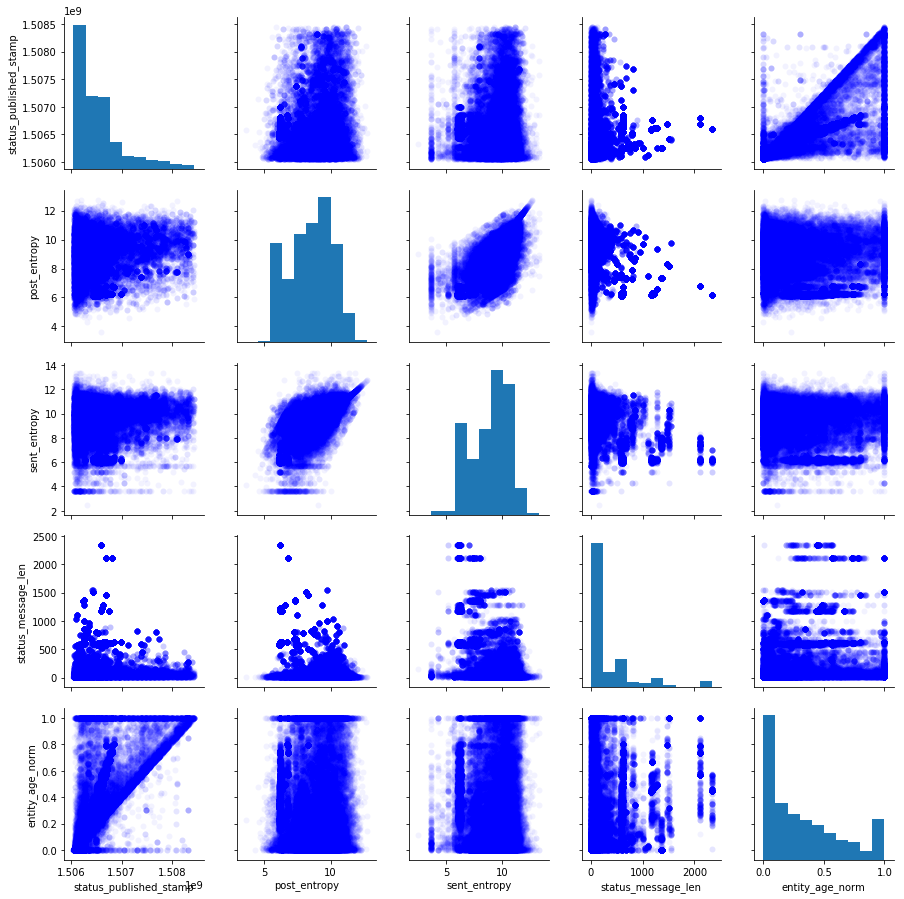

In [31]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
entropy_entity_data_late.loc[:, 'status_published_stamp'] = entropy_entity_data_late.loc[:, 'status_published'].apply(lambda x: x.timestamp())
sns.pairplot(entropy_entity_data_late.loc[:, ['status_published_stamp', 'post_entropy', 'sent_entropy', 'status_message_len', 'entity_age_norm']], plot_kws=dict(alpha=0.05, color='b', linewidth=0.))
plt.show()

Does age predict entropy to the same degree as message length?

In [32]:
import numpy as np
from statsmodels.formula.api import OLS
from sklearn.preprocessing import StandardScaler
# rescale time, age, status len for normal distributions
reg_data = entropy_entity_data_late.copy()
ivs = ['status_published_stamp', 'entity_age_norm', 'status_message_len']
non_norm_vars = ['status_published_stamp', 'entity_age_norm', 'status_message_len']
for v in non_norm_vars:
    reg_data.loc[:, v] = reg_data.loc[:, v].apply(lambda x: np.log(x+1e-3))
# norm scale everything
scaler = StandardScaler()
dvs = ['post_entropy', 'sent_entropy']
reg_data = pd.DataFrame(scaler.fit_transform(reg_data.loc[:, ivs+dvs].values), columns=ivs+dvs, index=reg_data.index)
for dv in dvs:
    ols_model = OLS(reg_data.loc[:, dv], reg_data.loc[:, ivs])
    results = ols_model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           post_entropy   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     4473.
Date:                Wed, 23 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:06:25   Log-Likelihood:                -67599.
No. Observations:               51846   AIC:                         1.352e+05
Df Residuals:                   51843   BIC:                         1.352e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp     0

Results:
- More time => more entropy
- More age => less entropy (confirmation!!)
- Longer message => less entropy (longer messages are more predictable?)

Does this result change if we account for the interaction between time/age?

In [33]:
reg_data.loc[:, 'time.x.age'] = reg_data.loc[:, 'status_published_stamp'] * reg_data.loc[:, 'entity_age_norm']
ivs = ['status_published_stamp', 'entity_age_norm', 'status_message_len', 'time.x.age']
dvs = ['post_entropy', 'sent_entropy']
for dv in dvs:
    ols_model = OLS(reg_data.loc[:, dv], reg_data.loc[:, ivs])
    results = ols_model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           post_entropy   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     3355.
Date:                Wed, 23 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:06:25   Log-Likelihood:                -67599.
No. Observations:               51846   AIC:                         1.352e+05
Df Residuals:                   51842   BIC:                         1.352e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp     0

The interaction of effects is insignificant and the overall effects remain the same.

Do these effects hold if we add a random effect for entity?

In [34]:
%%capture mixed_output
from statsmodels.formula.api import mixedlm
ivs = ['status_published_stamp', 'entity_age_norm', 'status_message_len']
dvs = ['post_entropy', 'sent_entropy']
reg_data.loc[:, 'entity'] = entropy_entity_data_late.loc[:, 'entity']
for dv in dvs:
    mixed_mod = mixedlm("%s ~ %s"%(dv, '+'.join(ivs)), reg_data, groups=reg_data.loc[:, 'entity'])
    mixed_res = mixed_mod.fit()
    print(mixed_res.summary())

In [35]:
mixed_output.show()

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   post_entropy
No. Observations:     51846     Method:               REML        
No. Groups:           3363      Scale:                0.5266      
Min. group size:      3         Likelihood:           -59634.2484 
Max. group size:      1588      Converged:            Yes         
Mean group size:      15.4                                        
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               0.150    0.011  14.200 0.000  0.129  0.171
status_published_stamp  0.092    0.004  20.479 0.000  0.083  0.101
entity_age_norm        -0.014    0.004  -3.338 0.001 -0.023 -0.006
status_message_len     -0.140    0.005 -29.110 0.000 -0.149 -0.131
Group Var               0.277    0.012                            

         

Effect is much weaker!! But still significant even controlling for the entity.

How about entity type? Ex. location vs. person vs. etc.

In [ ]:
%%capture model_output
reg_data.loc[:, 'entity_type'] = entropy_entity_data_late.loc[:, 'entity_type']
for type_e, data_e in reg_data.groupby('entity_type'):
    print('testing entity type %s with %d observations'%(type_e, data_e.shape[0]))
    for dv in dvs:
        mixed_mod = mixedlm("%s ~ %s"%(dv, '+'.join(ivs)), data_e, groups=data_e.loc[:, 'entity'])
        try:
            mixed_res = mixed_mod.fit()
            print(mixed_res.summary())
        except Exception as e:
            print('model fit failed because error:\n%s'%(e))

In [40]:
model_output.show()

testing entity type cause_of_death with 874 observations
              Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   post_entropy
No. Observations:    874       Method:               REML        
No. Groups:          23        Scale:                0.6616      
Min. group size:     3         Likelihood:           -1083.4712  
Max. group size:     434       Converged:            Yes         
Mean group size:     38.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.454    0.094  4.820 0.000  0.269  0.639
status_published_stamp  0.070    0.038  1.851 0.064 -0.004  0.144
entity_age_norm         0.211    0.053  4.013 0.000  0.108  0.314
status_message_len     -0.003    0.041 -0.072 0.942 -0.083  0.077
Group Var               0.138    

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/hg190/istewart6/miniconda3/envs/cri

Lots of interesting results! Not really what I was expecting at all.

- `city`: more age => lower entropy
- `country`: more age => higher entropy
- `date`: more age => higher entropy
- `location`: more age => lower entropy
- `misc`: more age => lower entropy (weak/insignificant)
- `organization`: more age => lower entropy (insignificant)
- `person`: more age => lower entropy (weak/insignificant)
- `state_or_province`: more age => higher entropy (insignificant)

Let's verify this with an OLS, in case the random effects are causing sparsity problems.

In [42]:
ivs = ['status_published_stamp', 'entity_age_norm', 'status_message_len']
dvs = ['post_entropy', 'sent_entropy']
for type_e, data_e in reg_data.groupby('entity_type'):
    print('testing entity type %s with %d observations'%(type_e, data_e.shape[0]))
    for dv in dvs:
        ols_mod = OLS(data_e.loc[:, dv], data_e.loc[:, ivs])
        try:
            ols_res = ols_mod.fit()
            print(ols_res.summary())
        except Exception as e:
            print('model fit failed because error:\n%s'%(e))

testing entity type cause_of_death with 874 observations
                            OLS Regression Results                            
Dep. Variable:           post_entropy   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     30.56
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           8.71e-19
Time:                        15:50:45   Log-Likelihood:                -1169.5
No. Observations:                 874   AIC:                             2345.
Df Residuals:                     871   BIC:                             2359.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:           sent_entropy   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.157
Date:                Wed, 23 Jan 2019   Prob (F-statistic):              0.336
Time:                        15:50:45   Log-Likelihood:                -51.982
No. Observations:                  49   AIC:                             110.0
Df Residuals:                      46   BIC:                             115.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp     0

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:           sent_entropy   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     1195.
Date:                Wed, 23 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:50:45   Log-Likelihood:                -14793.
No. Observations:               11391   AIC:                         2.959e+04
Df Residuals:                   11388   BIC:                         2.961e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp     0

The effects are largely reproduced.

- `city`: more age => lower entropy
- `country`: more age => lower entropy (weak/insignificant)
- `location`: more age => lower entropy
- `misc`: more age => lower entropy
- `organization`: more age => lower entropy
- `person`: more age => lower entropy
- `location`: more age => lower entropy (insignificant)

## Control for group
Does it matter which group is hosting the post?

In [47]:
entropy_entity_data_late.head()

,status_id,status_published,status_message,post_entropy,entity,sent_entropy,entity_type,status_message_len,entity_birth,entity_age,entity_age_norm,status_published_stamp
0,1773209126315380_1773953766240916,2017-09-22 03:13:06,algui que alla ido a el barrio_corazon.<ne.loc...,9.276696,barrio_corazon.<ne.location>,8.937995,location,30,2017-09-22 03:13:06,00:00:00,0.000000,1.506050e+09
1,1773209126315380_1774170326219260,2017-09-22 09:09:30,qui sab de la calle.<ne.misc> de el_carmen.<ne...,8.604492,barrio_corazon.<ne.location>,8.604492,location,13,2017-09-22 03:13:06,05:56:24,0.018800,1.506071e+09
2,1773209126315380_1774434496192843,2017-09-22 14:43:50,algui que conozc a henry_torres.<ne.person> de...,9.940711,barrio_corazon.<ne.location>,9.940711,location,24,2017-09-22 03:13:06,11:30:44,0.036437,1.506091e+09
3,1773209126315380_1774573232845636,2017-09-22 17:50:46,esto es lo que consegui de el barrio_corazon.<...,9.573975,barrio_corazon.<ne.location>,8.590873,location,45,2017-09-22 03:13:06,14:37:40,0.046297,1.506103e+09
4,1773209126315380_1774671916169101,2017-09-22 20:10:39,por favor si algui sab de ellos o los a vist p...,8.785576,barrio_corazon.<ne.location>,11.036489,location,28,2017-09-22 03:13:06,16:57:33,0.053676,1.506111e+09


In [49]:
entropy_entity_data_late.loc[:, 'group_id'] = entropy_entity_data_late.loc[:, 'status_id'].apply(lambda x: int(x.split('_')[0]))
display(entropy_entity_data_late.loc[:, 'group_id'].value_counts()[:10])

1773209126315380    8001
127217134598253     4407
132392547395104     4355
891721064308258     2704
119087272129297     2690
130913387550000     2431
1815374475420954    2154
1979604895658060    2104
721270821393500     2072
228066954387757     1896
Name: group_id, dtype: int64

In [50]:
reg_data.loc[:, 'group_id'] = entropy_entity_data_late.loc[:, 'group_id']

In [57]:
## mixed model
ivs = ['status_published_stamp', 'entity_age_norm', 'status_message_len']
dvs = ['post_entropy', 'sent_entropy']
for dv in dvs:
    mixed_mod = mixedlm("%s ~ %s"%(dv, '+'.join(ivs)), reg_data, groups=reg_data.loc[:, 'group_id'])
    mixed_res = mixed_mod.fit()
    print(mixed_res.summary())
## separate models
min_post_count = 100
for g_id, g_data in reg_data.groupby('group_id'):
    print('testing group %s with %d posts'%(g_id, g_data.shape[0]))
    if(g_data.shape[0] >= min_post_count):
        for dv in dvs:
            ols_mod = OLS(g_data.loc[:, dv], g_data.loc[:, ivs])
            ols_res = ols_mod.fit()
            print(ols_res.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    post_entropy
No. Observations:    51846      Method:                REML        
No. Groups:          58         Scale:                 0.7529      
Min. group size:     1          Likelihood:            -66326.2009 
Max. group size:     8001       Converged:             Yes         
Mean group size:     893.9                                         
-------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept               0.008    0.044    0.190 0.850 -0.077  0.094
status_published_stamp  0.156    0.005   32.624 0.000  0.146  0.165
entity_age_norm        -0.086    0.005  -17.791 0.000 -0.096 -0.077
status_message_len     -0.413    0.004 -100.842 0.000 -0.421 -0.405
Group Var               0.098    0.024                         

                            OLS Regression Results                            
Dep. Variable:           sent_entropy   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     9.271
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           1.03e-05
Time:                        16:46:48   Log-Likelihood:                -174.75
No. Observations:                 174   AIC:                             355.5
Df Residuals:                     171   BIC:                             365.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp     0

                            OLS Regression Results                            
Dep. Variable:           post_entropy   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.370
Date:                Wed, 23 Jan 2019   Prob (F-statistic):             0.0691
Time:                        16:46:48   Log-Likelihood:                -1250.8
No. Observations:                1013   AIC:                             2508.
Df Residuals:                    1010   BIC:                             2522.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp    -0

                            OLS Regression Results                            
Dep. Variable:           sent_entropy   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     9.708
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           3.41e-06
Time:                        16:46:49   Log-Likelihood:                -435.45
No. Observations:                 395   AIC:                             876.9
Df Residuals:                     392   BIC:                             888.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp    -0

                            OLS Regression Results                            
Dep. Variable:           sent_entropy   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     612.8
Date:                Wed, 23 Jan 2019   Prob (F-statistic):               0.00
Time:                        16:46:49   Log-Likelihood:                -10524.
No. Observations:                8001   AIC:                         2.105e+04
Df Residuals:                    7998   BIC:                         2.107e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
status_published_stamp     0

- The negative correlation holds in the random-effect model.
- The effects generally hold across groups (almost all groups with $N>1500$, many groups with $N>100$):
    - Exceptions where effect is reversed (more age => more entropy): `132963337341347`, `782660231920150`, `1306772706118778`

## Per-entropy analysis
Which entities show the strongest correlation between entropy and time?

In [75]:
entropy_entity_data_late.columns

Index(['status_id', 'status_published', 'status_message', 'post_entropy',
       'entity', 'sent_entropy', 'entity_type', 'status_message_len',
       'entity_birth', 'entity_age', 'entity_age_norm',
       'status_published_stamp', 'group_id'],
      dtype='object')

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.

,correl,p_val,entity,entity_type
0,1.0,0.0,jose_juan_cruz.<ne.person>,person
1,1.0,0.0,saez.<ne.person>,person
2,1.0,0.0,montadero.<ne.person>,person
3,1.0,0.0,bella_vista.<ne.organization>,organization
4,1.0,0.0,gracias_dlb.<ne.misc>,misc


,correl,p_val,entity,entity_type,count
0,1.0,0.0,jose_juan_cruz.<ne.person>,person,3
1,1.0,0.0,saez.<ne.person>,person,3
2,1.0,0.0,montadero.<ne.person>,person,3
3,1.0,0.0,bella_vista.<ne.organization>,organization,3
4,1.0,0.0,gracias_dlb.<ne.misc>,misc,3


,correl,p_val,entity,entity_type,count
187,0.905513,2.051221e-05,cdc.<ne.organization>,organization,13
200,0.881681,7.415948e-04,huracan_maria_vega_alta.<ne.person>,person,10
201,0.881144,1.428684e-05,dorado.<ne.organization>,organization,15
347,0.772592,3.222325e-03,compartan.<ne.organization>,organization,12
348,0.768293,9.431582e-03,pozuelo.<ne.location>,location,10
351,0.759458,4.146389e-05,yabucoa.<ne.organization>,organization,22
353,0.750241,7.821370e-03,infeccion.<ne.cause_of_death>,cause_of_death,11
354,0.747155,8.225646e-03,borinquen.<ne.location>,location,11
355,0.741490,3.720434e-03,banco.<ne.organization>,organization,13
356,0.740351,5.893755e-03,ojo_de_agua.<ne.city>,city,12


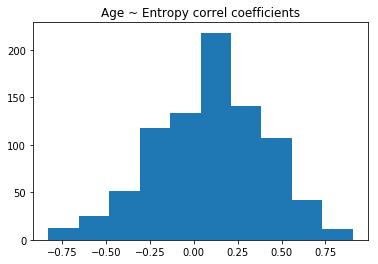

In [87]:
from scipy.stats import spearmanr
entropy_entity_data_late_correls = entropy_entity_data_late.groupby('entity').apply(lambda x: spearmanr(x.loc[:, 'entity_age_norm'], x.loc[:, 'sent_entropy']))
entropy_entity_data_late_correls = pd.DataFrame(entropy_entity_data_late_correls)
entropy_entity_data_late_correls.loc[:, 'correl'] = entropy_entity_data_late_correls.loc[:, 0].apply(lambda x: x[0])
entropy_entity_data_late_correls.loc[:, 'p_val'] = entropy_entity_data_late_correls.loc[:, 0].apply(lambda x: x[1])
entropy_entity_data_late_correls.drop(0, axis=1, inplace=True)
entropy_entity_data_late_correls.loc[:, 'entity'] = entropy_entity_data_late_correls.index
entropy_entity_data_late_correls.index = np.arange(len(entropy_entity_data_late_correls))
entropy_entity_data_late_correls.sort_values('correl', inplace=True, ascending=False)
# get entity type
entropy_entity_data_late_correls = pd.merge(entropy_entity_data_late_correls, entropy_entity_data_late.drop_duplicates('entity', inplace=False).loc[:, ['entity', 'entity_type']], on='entity')
## compute counts
entropy_entity_data_late_counts = pd.DataFrame(entropy_entity_data_late.loc[:, 'entity'].value_counts()).rename(columns={'entity':'count'})
entropy_entity_data_late_counts.loc[:, 'entity'] = entropy_entity_data_late_counts.index
entropy_entity_data_late_correls = pd.merge(entropy_entity_data_late_correls, entropy_entity_data_late_counts, on='entity')
entropy_entity_data_late_correls = entropy_entity_data_late_correls[~np.isnan(entropy_entity_data_late_correls.loc[:, 'correl'])]
## remove low-count entities
min_correl_count = 10
entropy_entity_data_late_correls = entropy_entity_data_late_correls[entropy_entity_data_late_correls.loc[:, 'count'] >= min_correl_count]
# entropy_entity_data_late_correls.sort_values('count', inplace=True, ascending=False)
display(entropy_entity_data_late_correls.head(20))
# plot all correlations
plt.hist(entropy_entity_data_late_correls.loc[:, 'correl'])
plt.title('Age ~ Entropy correl coefficients')
plt.show()

OK! Most entities have weak or insignificant correlations, and the significant ones tend to be positive. This contradicts the regression results, right?

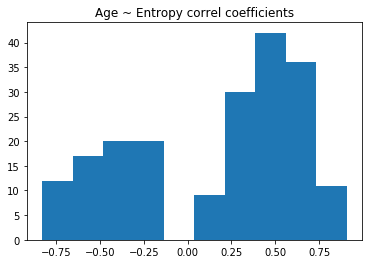

In [88]:
# just plot significant correlations
plt.hist(entropy_entity_data_late_correls[entropy_entity_data_late_correls.loc[:, 'p_val']<0.05].loc[:, 'correl'])
plt.title('Age ~ Entropy correl coefficients')
plt.show()

In [90]:
# breakdown per-type
for e_type, e_data in entropy_entity_data_late_correls.groupby('entity_type'):
    print('testing type %s'%(e_type))
    display(e_data.head(20))
    display(e_data.tail(20))

testing type cause_of_death


,correl,p_val,entity,entity_type,count
353,0.750241,7.821370e-03,infeccion.<ne.cause_of_death>,cause_of_death,11
383,0.704260,2.537636e-04,enfermedad.<ne.cause_of_death>,cause_of_death,22
426,0.666029,2.121088e-08,inundaciones.<ne.cause_of_death>,cause_of_death,56
512,0.585652,7.525122e-02,infecciones.<ne.cause_of_death>,cause_of_death,10
1053,0.355392,1.767423e-01,guerra.<ne.cause_of_death>,cause_of_death,16
1076,0.333611,5.383602e-02,enfermedades.<ne.cause_of_death>,cause_of_death,34
1097,0.320738,1.806201e-01,desastres.<ne.cause_of_death>,cause_of_death,19
1263,0.229713,1.123324e-01,tormenta.<ne.cause_of_death>,cause_of_death,49
1441,0.139698,3.543163e-03,huracan.<ne.cause_of_death>,cause_of_death,434
1530,0.095440,6.158919e-01,diabetes.<ne.cause_of_death>,cause_of_death,30


,correl,p_val,entity,entity_type,count
353,0.750241,7.821370e-03,infeccion.<ne.cause_of_death>,cause_of_death,11
383,0.704260,2.537636e-04,enfermedad.<ne.cause_of_death>,cause_of_death,22
426,0.666029,2.121088e-08,inundaciones.<ne.cause_of_death>,cause_of_death,56
512,0.585652,7.525122e-02,infecciones.<ne.cause_of_death>,cause_of_death,10
1053,0.355392,1.767423e-01,guerra.<ne.cause_of_death>,cause_of_death,16
1076,0.333611,5.383602e-02,enfermedades.<ne.cause_of_death>,cause_of_death,34
1097,0.320738,1.806201e-01,desastres.<ne.cause_of_death>,cause_of_death,19
1263,0.229713,1.123324e-01,tormenta.<ne.cause_of_death>,cause_of_death,49
1441,0.139698,3.543163e-03,huracan.<ne.cause_of_death>,cause_of_death,434
1530,0.095440,6.158919e-01,diabetes.<ne.cause_of_death>,cause_of_death,30


testing type city


,correl,p_val,entity,entity_type,count
356,0.740351,0.005894,ojo_de_agua.<ne.city>,city,12
414,0.667053,0.000271,los_angeles.<ne.city>,city,25
430,0.659649,0.019601,rio_abajo.<ne.city>,city,12
525,0.570595,0.084972,jacksonville.<ne.city>,city,10
526,0.570206,0.001901,chicago.<ne.city>,city,27
551,0.534957,0.111088,el_pueblito.<ne.city>,city,10
554,0.526866,0.000338,el_carmen.<ne.city>,city,42
572,0.509091,0.109737,salto.<ne.city>,city,11
578,0.503197,0.023719,arenas.<ne.city>,city,20
840,0.478501,0.083479,la_playa.<ne.city>,city,14


,correl,p_val,entity,entity_type,count
2085,-0.229800,0.239446,miramar.<ne.city>,city,28
2101,-0.248485,0.488776,san_cristobal.<ne.city>,city,10
2128,-0.273902,0.271400,el_valle.<ne.city>,city,18
2196,-0.316318,0.010883,la_ceiba.<ne.city>,city,64
2207,-0.327011,0.014815,metro.<ne.city>,city,55
2225,-0.343787,0.209608,campo.<ne.city>,city,15
2226,-0.345462,0.008489,manhattan.<ne.city>,city,57
2245,-0.369697,0.293050,vista.<ne.city>,city,10
2257,-0.390084,0.000843,cruces.<ne.city>,city,70
2341,-0.411520,0.000443,villas.<ne.city>,city,69


testing type country


,correl,p_val,entity,entity_type,count
369,0.734526,0.004243,alemania.<ne.country>,country,13
507,0.595747,0.069156,honduras.<ne.country>,country,10
556,0.526471,0.036167,cuba.<ne.country>,country,16
1238,0.248485,0.488776,borinquen.<ne.country>,country,10
1455,0.127751,0.571015,corea.<ne.country>,country,22
1456,0.127294,0.106480,estados_unidos.<ne.country>,country,162
1570,0.073355,0.003447,puerto_rico.<ne.country>,country,1588
1644,0.042634,0.757274,palestina.<ne.country>,country,55
1680,0.014011,0.965530,mexico.<ne.country>,country,12
1862,-0.097829,0.627357,eeuu.<ne.country>,country,27


,correl,p_val,entity,entity_type,count
369,0.734526,0.004243,alemania.<ne.country>,country,13
507,0.595747,0.069156,honduras.<ne.country>,country,10
556,0.526471,0.036167,cuba.<ne.country>,country,16
1238,0.248485,0.488776,borinquen.<ne.country>,country,10
1455,0.127751,0.571015,corea.<ne.country>,country,22
1456,0.127294,0.106480,estados_unidos.<ne.country>,country,162
1570,0.073355,0.003447,puerto_rico.<ne.country>,country,1588
1644,0.042634,0.757274,palestina.<ne.country>,country,55
1680,0.014011,0.965530,mexico.<ne.country>,country,12
1862,-0.097829,0.627357,eeuu.<ne.country>,country,27


testing type date


,correl,p_val,entity,entity_type,count
522,0.571482,0.002291,el_domingo.<ne.date>,date,26
532,0.561927,0.001859,martes.<ne.date>,date,28
829,0.491162,0.027866,el_viernes.<ne.date>,date,20
890,0.431957,0.017141,el_miercoles.<ne.date>,date,30
898,0.428571,0.143971,esta_noche.<ne.date>,date,13
1028,0.377691,0.033074,el_sabado.<ne.date>,date,32
1237,0.248698,0.000031,mañana.<ne.date>,date,274
1269,0.227495,0.072954,el_lunes.<ne.date>,date,63
1283,0.214985,0.026890,el_martes.<ne.date>,date,106
1301,0.200870,0.346621,octubre.<ne.date>,date,24


,correl,p_val,entity,entity_type,count
522,0.571482,0.002291,el_domingo.<ne.date>,date,26
532,0.561927,0.001859,martes.<ne.date>,date,28
829,0.491162,0.027866,el_viernes.<ne.date>,date,20
890,0.431957,0.017141,el_miercoles.<ne.date>,date,30
898,0.428571,0.143971,esta_noche.<ne.date>,date,13
1028,0.377691,0.033074,el_sabado.<ne.date>,date,32
1237,0.248698,0.000031,mañana.<ne.date>,date,274
1269,0.227495,0.072954,el_lunes.<ne.date>,date,63
1283,0.214985,0.026890,el_martes.<ne.date>,date,106
1301,0.200870,0.346621,octubre.<ne.date>,date,24


testing type ideology


,correl,p_val,entity,entity_type,count
1363,0.183225,0.530665,soto.<ne.ideology>,ideology,14
1485,0.110480,0.662534,espiritu.<ne.ideology>,ideology,18
1954,-0.159341,0.603088,carmelita.<ne.ideology>,ideology,13


,correl,p_val,entity,entity_type,count
1363,0.183225,0.530665,soto.<ne.ideology>,ideology,14
1485,0.110480,0.662534,espiritu.<ne.ideology>,ideology,18
1954,-0.159341,0.603088,carmelita.<ne.ideology>,ideology,13


testing type location


,correl,p_val,entity,entity_type,count
348,0.768293,9.431582e-03,pozuelo.<ne.location>,location,10
354,0.747155,8.225646e-03,borinquen.<ne.location>,location,11
370,0.716902,1.303648e-02,maunabo.<ne.location>,location,11
394,0.699763,1.774001e-07,canovanas.<ne.location>,location,43
500,0.600000,1.805009e-02,hayales.<ne.location>,location,15
520,0.572727,6.554305e-02,bendiga.<ne.location>,location,11
531,0.562338,7.967059e-03,sector.<ne.location>,location,21
579,0.501183,1.163037e-01,mavilla.<ne.location>,location,11
828,0.496503,1.006026e-01,porton.<ne.location>,location,12
836,0.480702,1.136642e-01,jueyes.<ne.location>,location,12


,correl,p_val,entity,entity_type,count
2089,-0.233634,0.089074,bohio.<ne.location>,location,54
2106,-0.253086,0.035890,barrio_sierra.<ne.location>,location,69
2122,-0.265765,0.024048,arroyo.<ne.location>,location,72
2220,-0.338306,0.144576,boricua.<ne.location>,location,20
2221,-0.338668,0.057956,trujillo_alto.<ne.location>,location,32
2231,-0.351137,0.239431,carraizo_trujillo_alto.<ne.location>,location,13
2240,-0.366291,0.018503,hospital.<ne.location>,location,41
2256,-0.390084,0.000843,escuela_epifanio_estrada.<ne.location>,location,70
2330,-0.405594,0.190836,jobos.<ne.location>,location,12
2346,-0.417270,0.000668,barrio_limones.<ne.location>,location,63


testing type misc


,correl,p_val,entity,entity_type,count
427,0.662983,0.001054,torre.<ne.misc>,misc,21
510,0.592657,0.007494,distribucion.<ne.misc>,misc,19
513,0.583589,0.076538,sept.<ne.misc>,misc,10
517,0.577309,0.012117,san_sebastian.<ne.misc>,misc,18
521,0.572215,0.041000,jose.<ne.misc>,misc,13
528,0.567851,0.068408,carolina.<ne.misc>,misc,11
537,0.551848,0.032942,masas_ii.<ne.misc>,misc,15
540,0.551848,0.032942,usos_multiples.<ne.misc>,misc,15
563,0.522125,0.055464,rios.<ne.misc>,misc,14
565,0.518427,0.016053,trabajo.<ne.misc>,misc,21


,correl,p_val,entity,entity_type,count
1962,-0.164104,6.505346e-01,control.<ne.misc>,misc,10
1973,-0.175454,1.917390e-01,parque.<ne.misc>,misc,57
1984,-0.180617,5.366308e-01,providencia.<ne.misc>,misc,14
2043,-0.202571,3.108994e-01,octubre.<ne.misc>,misc,27
2046,-0.203030,2.372469e-02,carretera.<ne.misc>,misc,124
2049,-0.204102,3.502333e-01,guayama.<ne.misc>,misc,23
2083,-0.229412,3.927205e-01,luz.<ne.misc>,misc,16
2095,-0.243994,1.242077e-01,leon.<ne.misc>,misc,41
2145,-0.287111,5.020240e-03,emergencia.<ne.misc>,misc,94
2200,-0.318907,3.391359e-01,dlb.<ne.misc>,misc,11


testing type nationality


,correl,p_val,entity,entity_type,count
1469,0.118740,0.638875,ingles.<ne.nationality>,nationality,18
1676,0.017001,0.930247,español.<ne.nationality>,nationality,29
2359,-0.445585,0.010594,puertorriqueño.<ne.nationality>,nationality,32
2613,-0.510460,0.108626,cubano.<ne.nationality>,nationality,11


,correl,p_val,entity,entity_type,count
1469,0.118740,0.638875,ingles.<ne.nationality>,nationality,18
1676,0.017001,0.930247,español.<ne.nationality>,nationality,29
2359,-0.445585,0.010594,puertorriqueño.<ne.nationality>,nationality,32
2613,-0.510460,0.108626,cubano.<ne.nationality>,nationality,11


testing type number


,correl,p_val,entity,entity_type,count
576,0.506051,0.064846,cinco.<ne.number>,number,14
1030,0.375143,0.000058,tres.<ne.number>,number,109
1150,0.300962,0.070285,one.<ne.number>,number,37
1241,0.247403,0.000004,dos.<ne.number>,number,341
1249,0.238339,0.507253,ocho.<ne.number>,number,10
1419,0.151915,0.391076,cuatro.<ne.number>,number,34
2062,-0.212793,0.412220,ten.<ne.number>,number,17


,correl,p_val,entity,entity_type,count
576,0.506051,0.064846,cinco.<ne.number>,number,14
1030,0.375143,0.000058,tres.<ne.number>,number,109
1150,0.300962,0.070285,one.<ne.number>,number,37
1241,0.247403,0.000004,dos.<ne.number>,number,341
1249,0.238339,0.507253,ocho.<ne.number>,number,10
1419,0.151915,0.391076,cuatro.<ne.number>,number,34
2062,-0.212793,0.412220,ten.<ne.number>,number,17


testing type organization


,correl,p_val,entity,entity_type,count
187,0.905513,0.000021,cdc.<ne.organization>,organization,13
201,0.881144,0.000014,dorado.<ne.organization>,organization,15
347,0.772592,0.003222,compartan.<ne.organization>,organization,12
351,0.759458,0.000041,yabucoa.<ne.organization>,organization,22
355,0.741490,0.003720,banco.<ne.organization>,organization,13
399,0.685816,0.019818,moca.<ne.organization>,organization,11
404,0.675703,0.005694,coqui.<ne.organization>,organization,15
428,0.662830,0.018816,atm.<ne.organization>,organization,12
440,0.651482,0.029884,toa_alta.<ne.organization>,organization,11
454,0.627856,0.009211,banco_popular.<ne.organization>,organization,16


,correl,p_val,entity,entity_type,count
2168,-0.305495,2.881699e-01,cocos.<ne.organization>,organization,14
2169,-0.305528,2.330775e-02,san_juan.<ne.organization>,organization,55
2170,-0.306263,1.061311e-01,alturas.<ne.organization>,organization,29
2172,-0.307630,8.107383e-03,collores.<ne.organization>,organization,73
2174,-0.310506,3.527148e-01,centro_medico.<ne.organization>,organization,11
2176,-0.313713,5.726101e-04,cidra.<ne.organization>,organization,117
2209,-0.328395,2.143019e-01,copy.<ne.organization>,organization,16
2219,-0.336393,3.419090e-01,oasis.<ne.organization>,organization,10
2238,-0.360681,1.720233e-03,parcelas_nuevas.<ne.organization>,organization,73
2327,-0.403681,1.982299e-02,s.<ne.organization>,organization,33


testing type person


,correl,p_val,entity,entity_type,count
200,0.881681,0.000742,huracan_maria_vega_alta.<ne.person>,person,10
385,0.703756,0.000258,beatriz.<ne.person>,person,22
396,0.694162,0.025942,muñoz_rivera.<ne.person>,person,10
441,0.650959,0.004652,jay_fonseca.<ne.person>,person,17
442,0.649943,0.006422,mc.<ne.person>,person,16
508,0.594223,0.032226,milagros.<ne.person>,person,13
524,0.570986,0.013326,papi.<ne.person>,person,18
538,0.551848,0.032942,felix_pedraza.<ne.person>,person,15
542,0.551515,0.098401,javier.<ne.person>,person,10
555,0.526694,0.043678,manuel_t_guillen.<ne.person>,person,15


,correl,p_val,entity,entity_type,count
2224,-0.343632,0.137961,hernandez.<ne.person>,person,20
2230,-0.350606,0.003376,demetrio_rivera.<ne.person>,person,68
2232,-0.353344,0.126452,nesecito.<ne.person>,person,20
2237,-0.359427,0.206888,nilda.<ne.person>,person,14
2244,-0.368617,0.160045,bully.<ne.person>,person,16
2252,-0.371901,0.210831,sanchez.<ne.person>,person,13
2353,-0.434462,0.092646,mendez.<ne.person>,person,16
2357,-0.441447,0.076076,mayaguez.<ne.person>,person,17
2379,-0.479452,0.135631,maribel.<ne.person>,person,11
2386,-0.494468,0.051532,sabana_hoyos.<ne.person>,person,16


testing type religion


,correl,p_val,entity,entity_type,count
506,0.595776,0.003436,iglesia_catolica.<ne.religion>,religion,22


,correl,p_val,entity,entity_type,count
506,0.595776,0.003436,iglesia_catolica.<ne.religion>,religion,22


testing type state_or_province


,correl,p_val,entity,entity_type,count
564,0.521115,0.006337,connecticut.<ne.state_or_province>,state_or_province,26
831,0.487056,0.034432,massachusetts.<ne.state_or_province>,state_or_province,19
1088,0.322971,0.087472,california.<ne.state_or_province>,state_or_province,29
1235,0.249893,0.001166,florida.<ne.state_or_province>,state_or_province,166
1242,0.245769,0.358873,new_jersey.<ne.state_or_province>,state_or_province,16
1381,0.172059,0.192549,texas.<ne.state_or_province>,state_or_province,59
1474,0.115385,0.707390,ohio.<ne.state_or_province>,state_or_province,13
1792,-0.042424,0.907364,pensilvania.<ne.state_or_province>,state_or_province,10
1937,-0.147741,0.462090,virginia.<ne.state_or_province>,state_or_province,27
2094,-0.243396,0.445879,washington.<ne.state_or_province>,state_or_province,12


,correl,p_val,entity,entity_type,count
564,0.521115,0.006337,connecticut.<ne.state_or_province>,state_or_province,26
831,0.487056,0.034432,massachusetts.<ne.state_or_province>,state_or_province,19
1088,0.322971,0.087472,california.<ne.state_or_province>,state_or_province,29
1235,0.249893,0.001166,florida.<ne.state_or_province>,state_or_province,166
1242,0.245769,0.358873,new_jersey.<ne.state_or_province>,state_or_province,16
1381,0.172059,0.192549,texas.<ne.state_or_province>,state_or_province,59
1474,0.115385,0.707390,ohio.<ne.state_or_province>,state_or_province,13
1792,-0.042424,0.907364,pensilvania.<ne.state_or_province>,state_or_province,10
1937,-0.147741,0.462090,virginia.<ne.state_or_province>,state_or_province,27
2094,-0.243396,0.445879,washington.<ne.state_or_province>,state_or_province,12


testing type title


,correl,p_val,entity,entity_type,count
401,0.683300,3.523727e-03,helicoptero.<ne.title>,title,16
438,0.654371,4.008407e-02,jefe.<ne.title>,title,10
463,0.613187,1.970633e-02,pastor.<ne.title>,title,14
505,0.599537,3.402848e-10,medico.<ne.title>,title,91
553,0.527059,6.743313e-04,segundo.<ne.title>,title,38
855,0.466599,5.407534e-03,bendito.<ne.title>,title,34
857,0.464804,5.195792e-02,doctor.<ne.title>,title,18
885,0.438900,7.798482e-02,reportero.<ne.title>,title,17
912,0.415406,1.580634e-01,guardia.<ne.title>,title,13
1064,0.348258,2.565836e-02,maestra.<ne.title>,title,41


,correl,p_val,entity,entity_type,count
1089,0.322876,0.153415,representante.<ne.title>,title,21
1187,0.280605,0.353073,marina.<ne.title>,title,13
1240,0.247482,0.128767,dueño.<ne.title>,title,39
1384,0.168565,0.620280,dueña.<ne.title>,title,11
1402,0.157882,0.330557,rey.<ne.title>,title,40
1421,0.149037,0.581714,secretaria.<ne.title>,title,16
1494,0.105999,0.230028,gobernador.<ne.title>,title,130
1504,0.103593,0.083015,alcalde.<ne.title>,title,281
1564,0.077135,0.802229,secretario.<ne.title>,title,13
1601,0.059932,0.609513,general.<ne.title>,title,75


## Test appositives/descriptors
How many mentions of entities actually have descriptors?

In [1]:
import pandas as pd
from ast import literal_eval
entity_data_tagged = pd.read_csv('../../data/facebook-maria/combined_group_data_es_tagged.tsv', sep='\t', index_col=False)
print('%d original statuses'%(entity_data_tagged.shape[0]))
# convert lists
entity_data_tagged.loc[:, 'status_message_tags'] = entity_data_tagged.loc[:, 'status_message_tags'].apply(literal_eval)
entity_data_tagged.loc[:, 'status_message_tags_ne'] = entity_data_tagged.loc[:, 'status_message_tags_ne'].apply(literal_eval)
# get rid of extra-long statuses
max_status_len = 150
entity_data_tagged = entity_data_tagged[entity_data_tagged.loc[:, 'status_message_clean'].apply(lambda x: len(x.split(' '))) < max_status_len]
print('%d filtered statuses'%(entity_data_tagged.shape[0]))
display(entity_data_tagged.head())

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


23662 original statuses
23004 filtered statuses


,group_id,status_author_id,status_message,status_lang,status_id,status_published,status_message_clean,status_message_tags,status_message_tags_ne,status_message_ne_tagged_stemmed
0,351272391991842,10159623474155515,Estoy preocupada por mi tia vicky vazquez que ...,es,351272391991842_362333787552369,2017-10-19 18:25:23,Estoy preocupada por mi tia vicky vazquez que ...,"[(Estoy, O), (preocupada, O), (por, O), (mi, O...","[(asma, CAUSE_OF_DEATH), (Dorado, ORGANIZATION)]",estoy preocup por mi tia vicky vazquez que des...
2,351272391991842,1716175958400853,En apoyo al alcalde Carlos Lopez y al municipi...,es,351272391991842_361453717640376,2017-10-17 17:38:08,En apoyo al alcalde Carlos Lopez y al municipi...,"[(En, O), (apoyo, O), (a, O), (el, O), (alcald...","[(alcalde, TITLE), (Carlos Lopez, PERSON), (Do...",en apoy a el alcalde.<ne.title> carlos_lopez.<...
3,351272391991842,141039043205101,Pueblo de Puerto Rico no se monten en las gran...,es,351272391991842_358929311226150,2017-10-11 14:14:22,Pueblo de Puerto Rico no se monten en las gran...,"[(Pueblo, O), (de, O), (Puerto, COUNTRY), (Ric...","[(Puerto Rico, COUNTRY), (America, MISC), (Pue...",puebl de puerto_rico.<ne.country> no se mont e...
5,351272391991842,2060154724214607,"Guayama, Dorado, y Piñones",es,351272391991842_357797888005959,2017-10-08 14:52:49,"Guayama, Dorado, y Piñones","[(Guayama, LOCATION), (,, O), (Dorado, O), (,,...","[(Guayama, LOCATION)]","guayama.<ne.location>, dor, y piñones.<ne.person>"
6,351272391991842,2060154724214607,Videos de Dorado dos semanas despues del Hurac...,es,351272391991842_356944798091268,2017-10-06 13:12:14,Videos de Dorado dos semanas despues del Hurac...,"[(Videos, O), (de, O), (Dorado, O), (dos, NUMB...","[(dos, NUMBER)]",vide de dor dos.<ne.number> seman despu de el ...


In [2]:
loc_types = ['COUNTRY', 'CITY', 'LOCATION']
loc_idx = entity_data_tagged.loc[:, 'status_message_tags_ne'].apply(lambda x: len([y[1] in loc_types for y in x]) > 0)
loc_idx = loc_idx[loc_idx].index.tolist()
entity_data_tagged_loc = entity_data_tagged.loc[loc_idx, :]
print('\n'.join(entity_data_tagged_loc.loc[:, 'status_message_clean'].iloc[280:300]))

Dios les Bendiga..Ojo 👀 precaución amistades, familias, vecinos Precaución...Les comparto esta información:ATENCIÓN: Absolutamente nadie le puede cobrar por llenar las ayudas de FEMA. Nos están llegando confidencias de que ciudadanos se están aprovechando de la situación (falta de energía e internet) y están cobrando hasta $25 por llenar las ayudas. ESTO ES ILEGAL Y LA PERSONA QUE LO HAGA PUEDE SER PROCESADA EN EL FORO FEDERAL. Si conoce de alguien que se esté aprovechando del más necesitado para generar algún ingreso, denúncielo. Compártelo.Gracias.
Alguien sabe si ya western union o cualquier otro Tipo de envio de dinero está funcionando cerca Del pueblo de Corozal?
El Alcalde de Corozal habla y recibe ayuda de la Alcadesa de San Juan...
Corozal necesita agua por favor tratar de ir a las casas en el Barrio Palmarejo sector febus mucha jente si agua.
Si alguien de Corozal, sabe de Las familias Avilés, Marrero de Cuchillas, Díaz de Maguelles o relacionados favor de llamar a Roberto Día

In [3]:
import re
test_locs = ['higuillar', 'dorado', 'corozal', 'palmarejo', 'barranquitas', 'san germán']
for test_loc_i in test_locs:
    test_loc_i_matcher = re.compile(test_loc_i)
    entity_data_tagged_i = entity_data_tagged[entity_data_tagged.loc[:, 'status_message_clean'].apply(lambda x: test_loc_i_matcher.search(x.lower()) is not None)]
    print('\n'.join(entity_data_tagged_i.loc[:, 'status_message_clean'].values))

Estoy preocupada por mi tia vicky vazquez que desde el dia antes del huracan no se de ella pues ella es una mujer enferma tiene que usar oxijeno y ella me dijo el dia antes del huracan que su oxijeno se avia acabado y que no se sentia bien pero que se estava dando terapias con la maquina del asma ella vive en higuillar en Dorado creo qye se llama arenar en la calle que vive al frente de su casa antes hera una vaqueria yo espero que ella este bien por favor si alguien del grupo es de esa aria y la conose digale que su sobrina la esta buscando gracias por favor de compartir
Buenas noches.. busco información del barrio higuillar en el area frente a granas lindas.. al lado del colmadito del difunto Pereda.. tengo una tía q vive ahí se llama carmín nieves.. agradeceré cualquier información de ella o de esa área en la q ella vive... gracias
Deseo saber sobre el bienestar de mi hermano Armando Sánchez y su esposa Adela Le Ravén, de mi sobrino Ián Yarel Sánchez y su esposa Nancy. Residen en Ba

Alguien tiene informacion de Haciendas del Dorado hacia Corozal?
Mi gente pasó por aquí a informarles que mañana estará Fema en la cancha bajo techo de mi pueblo Corozal hoy estuvieron todo el día mañana será el ultimo día que estarán llenando formularios para las personas que aún no los a llenado aproveche mi gente rieguen la voz que van a estar todo el día de mañana linda noche
Corozal en la lista de aguas contaminadas tengan cuidado
Alguien me puede decir como esta el clima en Corozal?? Son lad 10:36pm y mi prima de Puerto Rico me acaba de llamar y dice q los vientos estan demasiados de fuertes alla, estaba asustada xq no sabia si es una tormenta tropical o q xq los vientos estan fuertes ahora mismo. Vive en Padilla Ermita. No veo nada aqui en FB del tiempo pero no se si es q en Corozal o en PR estan incomunicados ahora x el mal tiempo q esta pasando. Sus ventanas de cristales dice q hacen un ruido feo. X favor dejenmen saber
📬El correo de COROZAL, está funcionando??? Alguien le ha 

Hable con Widalise Ortiz y me dijo que han estado trabajando en el puente de la Vega de Maná todo el día (poniendo tosca) y que se supone haya paso para las 6pm. Me dijo qué hay señal en su casa (en las Montañas en mana!) en vista Del Mar en negros y en el pabellón en Barranquitas!
Entre Naranjito y Barranquitas
Estoy buscando a mi familia que estaban en barranquitas me dijeron que estaban Refugio parcelas emanueli el nombre de ella es María Morales en mi abuelo se llama Jerónimo Rivera
Alguien me puede dar informacion de Barranquitas!!!?? Hay informacion de todos los pueblos menos de Barranquitas!!!
Alguien sabe de Barranquitas. Hay fam. alla y en Canales de Hato Rey. Gracias.
Area central de Puerto Rico esta en el Olvido Riega l voz Comerio,Aguas buena,Bayamon,Caguas,cidray Barranquitas no ls mencionan
hola Barranquitas se levanta precente sieres boricua dime WEEEEEPA para que tu sepa DLB
Alerta!!! En el Barrio Palo Hincado subiendo por puente roto una pandilla trató de entrar a una 

Possible descriptors:

- PP => `en Dorado`, `en el area frente a granas lindas`, `La Guarida del Penon, en Rosario Peñon, en San Germán`, `Barrio negro en Corozal`, `Barrio Palmarejo de Coamo`, `sector Palmarejo de Coamo`, `Los LLANOS de Coamo Barrio Cuyon Palmarejo`, `del Cerro en Palmarejo`, `del supermercado Alcoba en Palmarejo`, `El Rancho en Palmarejo`, `en Canales de Hato Rey`, `Jardines de Barranquitas`, `Las Bromelias en Barranquitas`
- NP => `del barrio higuillar`, `Corozal PR`, `Barrio Palmarejo`, `el rio de Palmarejo, Corozal`, `sector Pancho Febus`, `Sector los llanos en Palmarejo`, `Coamo Sector Palmarejo`, `Barrio Palmarejo y Barrio Cuyon`, `Dorado Calle Norte`, `Palmarejo sector las Cantera`, `el Barrio Palmarejo sector febus`, `Los Guardias, El Rancho Palmarejo Corozal`, `Palmarejo sector los guardias`, `sector la loma`, `La Loma Sector el Tiguere Barranquitas`, `en Palo Hincado, sector Puente Roto`

How does it look when we parse these sentences?

Let's get 10 example sentences, run them through the parsers and see which one does the least badly.

- Install/run Google parser: https://cloud.google.com/python/
- Run Stanford parser:
```
cd /hg190/corpora/StanfordCoreNLP/stanford-corenlp-full-2018-02-27
java -Xmx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -serverProperties StanfordCoreNLP-spanish.properties -preload tokenize,ssplit,pos,ner,parse -status_port 9003  -port 9003 -timeout 15000
```

In [28]:
## Google parse testing
import json
from google.cloud import language
google_cred_file = '../../data/Google_cloud/TestProject_creds.json'
google_creds = json.load(open(google_cred_file))
google_client = language.LanguageServiceClient(credentials=google_creds)
google_client = language.LanguageServiceClient.from_service_account_json(google_cred_file)
test_sent = 'Ella vive en Palo Hincado, sector Puente Roto.'
test_doc = language.types.Document(
    content=test_sent,
    type=language.enums.Document.Type.PLAIN_TEXT
)
test_parse = google_client.analyze_syntax(test_doc, retry=False)
print(test_parse)

sentences {
  text {
    content: "Ella vive en Palo Hincado, sector Puente Roto."
    begin_offset: -1
  }
}
tokens {
  text {
    content: "Ella"
    begin_offset: -1
  }
  part_of_speech {
    tag: PRON
    case: NOMINATIVE
    gender: FEMININE
    number: SINGULAR
    person: THIRD
    proper: NOT_PROPER
  }
  dependency_edge {
    head_token_index: 1
    label: NSUBJ
  }
  lemma: "\303\211l"
}
tokens {
  text {
    content: "vive"
    begin_offset: -1
  }
  part_of_speech {
    tag: VERB
    aspect: IMPERFECTIVE
    mood: INDICATIVE
    number: SINGULAR
    person: THIRD
    proper: NOT_PROPER
    tense: PRESENT
    voice: ACTIVE
  }
  dependency_edge {
    head_token_index: 1
    label: ROOT
  }
  lemma: "vivir"
}
tokens {
  text {
    content: "en"
    begin_offset: -1
  }
  part_of_speech {
    tag: ADP
    proper: NOT_PROPER
  }
  dependency_edge {
    head_token_index: 1
    label: PREP
  }
  lemma: "en"
}
tokens {
  text {
    content: "Palo"
    begin_offset: -1
  }
  part_

In [171]:
import re
import spacy
from spacy.language import DependencyParser
spacy_nlp = spacy.load('es')
from nltk.parse.corenlp import CoreNLPParser, CoreNLPDependencyParser
stanford_parser = CoreNLPDependencyParser(url='http://localhost:9003')
# stanford_parser = CoreNLPParser(url='http://localhost:9003', tagtype='ner') # Chomsky graphs
from google.cloud import language
google_cred_file = '../../data/Google_cloud/TestProject_creds.json'
google_client = language.LanguageServiceClient.from_service_account_json(google_cred_file)

def build_parse(parse_result, parse_type='spacy'):
    parse_tuples = [] # token, POS, head_index, dependency label
    # get tokens
    if(parse_type == 'spacy'):
        parse_tokens = parse_result
    elif(parse_type == 'stanford'):
        parse_tokens = sorted(parse_result.nodes.items(), key=lambda x: x[0])[1:] # skip the first token
    elif(parse_type == 'google'):
        parse_tokens = parse_result.__getattribute__('tokens')
    # get tuple for each token
    google_pos_matcher = re.compile('(?<=tag: ).+')
    google_dep_label_matcher = re.compile('(?<=label: ).+')
    for token in parse_tokens:
        if(parse_type == 'spacy'):
            parse_tuple = [
                token.text, 
                token.pos_,
                token.head.i,
                token.dep_,
            ]
        elif(parse_type == 'stanford'):
            idx, tok = token
            parse_tuple = [
                tok['word'],
                tok['tag'],
                tok['head'],
                tok['rel'],
            ]
        elif(parse_type == 'google'):
#             print(token)
#             print(token.__getattribute__('part_of_speech'))
#             print(token.__getattribute__('dependency_edge'))
            parse_tuple = [token.__getattribute__('text').__getattribute__('content'), 
                           google_pos_matcher.search(str(token.__getattribute__('part_of_speech'))).group(0),
                           token.__getattribute__('dependency_edge').__getattribute__('head_token_index'),
                           google_dep_label_matcher.search(str(token.__getattribute__('dependency_edge'))).group(0).lower(),
                          ]
        parse_tuples.append(parse_tuple)
    return parse_tuples

test_sents = [
    "Ella vive en Palo Hincado, sector Puente Roto.", 
    "Hola, mi esposo Efrain J Irizarry y su hermano Nelson Irizarry andan buscando a su Papa y su esposa, Mayra Rodriguez dueños de La Guarida del Penon, en Rosario Peñon, en San Germán.",
    "Estoy buscando información acerca de El Rancho en Palmarejo.",
    "Necesito saber de mi papá vive solo, justo al lado del supermercado Alcoba en Palmarejo un segundo piso casa con techo de zinc",
    "Alguien que me diga respecto a Las Bromelias en Barranquitas?",
    "busco información del barrio higuillar en el area frente a granas lindas",
    "Hay fam. alla y en Canales de Hato Rey.",
    "Area de los Los Guardias, El Rancho Palmarejo Corozal.",
    "Todavia nada de Dorado Calle Norte?",
    "Sector los llanos en Palmarejo no visto ayuda alguna mi hermana tiene MA's de doce personas a su cargo incluyendo Menores.",
]
# test_sent = "Mi familia y vecinos en el rio de Palmarejo, Corozal"

spacy_trees = []
stanford_trees = []
google_trees = []

for test_sent in test_sents:
    print('parsing sentence "%s"'%(test_sent))
    ## spacy
#     print('testing spacy parser')
    spacy_doc = spacy_nlp(test_sent)
    spacy_tree = build_parse(spacy_doc, 'spacy')
    spacy_trees.append(spacy_tree)
#     print(spacy_doc.print_tree())

    ## Stanford
#     print('testing Stanford parser')
    stanford_parse = stanford_parser.parse_one(stanford_parser.tokenize(test_sent))
    stanford_tree = build_parse(stanford_parse, 'stanford')
    stanford_trees.append(stanford_tree)
#     print(next(stanford_parse))
    
    ## Google SyntaxNet
#     print('testing Google parser')
    google_doc = language.types.Document(
        content=test_sent,
        type=language.enums.Document.Type.PLAIN_TEXT
    )
    google_parse = google_client.analyze_syntax(google_doc, retry=False)
    google_tree = build_parse(google_parse, 'google')
    google_trees.append(google_tree)

parsing sentence "Ella vive en Palo Hincado, sector Puente Roto."
parsing sentence "Hola, mi esposo Efrain J Irizarry y su hermano Nelson Irizarry andan buscando a su Papa y su esposa, Mayra Rodriguez dueños de La Guarida del Penon, en Rosario Peñon, en San Germán."
parsing sentence "Estoy buscando información acerca de El Rancho en Palmarejo."
parsing sentence "Necesito saber de mi papá vive solo, justo al lado del supermercado Alcoba en Palmarejo un segundo piso casa con techo de zinc"
parsing sentence "Alguien que me diga respecto a Las Bromelias en Barranquitas?"
parsing sentence "busco información del barrio higuillar en el area frente a granas lindas"
parsing sentence "Hay fam. alla y en Canales de Hato Rey."
parsing sentence "Area de los Los Guardias, El Rancho Palmarejo Corozal."
parsing sentence "Todavia nada de Dorado Calle Norte?"
parsing sentence "Sector los llanos en Palmarejo no visto ayuda alguna mi hermana tiene MA's de doce personas a su cargo incluyendo Menores."


In [172]:
for sent_i, spacy_i, stanford_i, google_i in zip(test_sents, spacy_trees, stanford_trees, google_trees):
    print('test sentence = "%s"'%(sent_i))
    print('spacy')
    print(spacy_i)
    print('stanford')
    print(stanford_i)
    print('google')
    print(google_i)

test sentence = "Ella vive en Palo Hincado, sector Puente Roto."
spacy
[['Ella', 'PRON', 1, 'nsubj'], ['vive', 'VERB', 1, 'ROOT'], ['en', 'ADP', 3, 'case'], ['Palo', 'PROPN', 1, 'obl'], ['Hincado', 'PROPN', 3, 'flat'], [',', 'PUNCT', 6, 'punct'], ['sector', 'NOUN', 3, 'appos'], ['Puente', 'PROPN', 6, 'appos'], ['Roto', 'PROPN', 7, 'flat'], ['.', 'PUNCT', 1, 'punct']]
stanford
[['Ella', 'PRON', 2, 'nsubj'], ['vive', 'VERB', 0, 'ROOT'], ['en', 'ADP', 4, 'case'], ['Palo', 'PROPN', 2, 'nmod'], ['Hincado', 'ADJ', 4, 'amod'], [',', 'PUNCT', 7, 'punct'], ['sector', 'NOUN', 4, 'appos'], ['Puente', 'PROPN', 7, 'appos'], ['Roto', 'PROPN', 8, 'name'], ['.', 'PUNCT', 2, 'punct']]
google
[['Ella', 'PRON', 1, 'nsubj'], ['vive', 'VERB', 1, 'root'], ['en', 'ADP', 1, 'prep'], ['Palo', 'NOUN', 2, 'pobj'], ['Hincado', 'NOUN', 3, 'appos'], [',', 'PUNCT', 3, 'p'], ['sector', 'NOUN', 3, 'conj'], ['Puente', 'PUNCT', 3, 'prep'], ['Roto', 'ADJ', 7, 'pobj'], ['.', 'PUNCT', 1, 'p']]
test sentence = "Hola, mi esp

In [221]:
import networkx as nx
# define method for extracting dependency relations
def extract_dep(tree, dedup_subtrees=False):
    # identify PROPN, then identify any attached appositive/PP phrases
    noun_types = ['NOUN', 'PROPN']
    tree = [x + [i] for i,x in enumerate(tree)] # add index for bookkeeping
    np_heads = list(filter(lambda x: x[1] in noun_types, tree))
#     print('got np heads %s'%(str(np_heads)))
    np_descendants = []
    ## TODO: build graph, then extract subtrees?? would be cleaner than this
    tree_graph = nx.DiGraph()
    for i, dep in enumerate(tree):
        tree_graph.add_edge(dep[2], i, pos=dep[1], name='/'.join(map(str, dep)), dep=dep)
    for np_head_i in np_heads:
        idx = np_head_i[4]
        # collect descendents
        desc_i = nx.descendants(tree_graph, idx)
        desc_i = [np_head_i] + [tree[j] for j in desc_i]
        # sort by sentence order
        desc_i = sorted(desc_i, key=lambda x: x[4])
        np_descendants.append(desc_i)
    # get rid of subordinate (duplicate) trees
    if(dedup_subtrees):
        np_descendants_dedup = []
        np_descendants_dedup_str = []
        np_descendants_str = list(map(lambda x: list(map(lambda y: '/'.join(map(str, y)), x)), np_descendants))
        for desc_i in sorted(np_descendants, key=lambda x: len(x), reverse=True):
    #         print('testing desc %s'%(desc_i))
            desc_str = list(map(lambda x: '/'.join(map(str, x)), desc_i))
            prev_match = False
            for np_descendants_dedup_str_i in np_descendants_dedup_str:
                if(len(set(np_descendants_dedup_str_i) - set(desc_str)) < len(np_descendants_dedup_str_i)):
                    prev_match = True
                    break
            if(not prev_match):
    #             print('adding desc %s'%(desc_str))
                np_descendants_dedup_str.append(desc_str)
                np_descendants_dedup.append(desc_i)
        np_descendants = np_descendants_dedup
    return np_descendants
tree_i = spacy_trees[0]
def pretty_print_tree(tree):
    tree_str = ' '.join(map(lambda x: '/'.join(map(str, x)), tree))
    return tree_str
print(pretty_print_tree(tree_i))
descendants = extract_dep(tree_i)
# print(descendants)
for des in descendants:
    print(des)

Ella/PRON/1/nsubj vive/VERB/1/ROOT en/ADP/3/case Palo/PROPN/1/obl Hincado/PROPN/3/flat ,/PUNCT/6/punct sector/NOUN/3/appos Puente/PROPN/6/appos Roto/PROPN/7/flat ./PUNCT/1/punct
[['en', 'ADP', 3, 'case', 2], ['Palo', 'PROPN', 1, 'obl', 3], ['Hincado', 'PROPN', 3, 'flat', 4], [',', 'PUNCT', 6, 'punct', 5], ['sector', 'NOUN', 3, 'appos', 6], ['Puente', 'PROPN', 6, 'appos', 7], ['Roto', 'PROPN', 7, 'flat', 8]]
[['Hincado', 'PROPN', 3, 'flat', 4]]
[[',', 'PUNCT', 6, 'punct', 5], ['sector', 'NOUN', 3, 'appos', 6], ['Puente', 'PROPN', 6, 'appos', 7], ['Roto', 'PROPN', 7, 'flat', 8]]
[['Puente', 'PROPN', 6, 'appos', 7], ['Roto', 'PROPN', 7, 'flat', 8]]
[['Roto', 'PROPN', 7, 'flat', 8]]


In [228]:
for i, (test_sent_i, spacy_tree_i, stanford_tree_i, google_tree_i) in enumerate(zip(test_sents, spacy_trees, stanford_trees, google_trees)):
    print('%d. %s'%(i+1, test_sent_i))
    spacy_descendants_i = extract_dep(spacy_tree_i)
    print('spacy dep\n%s'%('\n'.join(map(pretty_print_tree, spacy_descendants_i))))
    stanford_descendants_i = extract_dep(stanford_tree_i)
    print('stanford dep\n%s'%('\n'.join(map(pretty_print_tree, stanford_descendants_i))))
    google_descendants_i = extract_dep(google_tree_i)
    print('google dep\n%s'%('\n'.join(map(pretty_print_tree, google_descendants_i))))
    print('~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~')
#     print("spacy dep\n%s"%(spacy_descendants_i))
#     print("stanford dep\n%s"%(stanford_descendants_i))
#     print("google dep\n%s"%(google_descendants_i))

1. Ella vive en Palo Hincado, sector Puente Roto.
spacy dep
en/ADP/3/case/2 Palo/PROPN/1/obl/3 Hincado/PROPN/3/flat/4 ,/PUNCT/6/punct/5 sector/NOUN/3/appos/6 Puente/PROPN/6/appos/7 Roto/PROPN/7/flat/8
Hincado/PROPN/3/flat/4
,/PUNCT/6/punct/5 sector/NOUN/3/appos/6 Puente/PROPN/6/appos/7 Roto/PROPN/7/flat/8
Puente/PROPN/6/appos/7 Roto/PROPN/7/flat/8
Roto/PROPN/7/flat/8
stanford dep
Palo/PROPN/2/nmod/3
sector/NOUN/4/appos/6
,/PUNCT/7/punct/5 Puente/PROPN/7/appos/7
Roto/PROPN/8/name/8
google dep
Palo/NOUN/2/pobj/3 Hincado/NOUN/3/appos/4 ,/PUNCT/3/p/5 sector/NOUN/3/conj/6 Puente/PUNCT/3/prep/7 Roto/ADJ/7/pobj/8
Hincado/NOUN/3/appos/4
sector/NOUN/3/conj/6
~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~*~
2. Hola, mi esposo Efrain J Irizarry y su hermano Nelson Irizarry andan buscando a su Papa y su esposa, Mayra Rodriguez dueños de La Guarida del Penon, en Rosario Peñon, en San Germán.
spacy dep
Hola/PROPN/13/nsubj/0 ,/PUNCT/0/punct/1 mi/DET/3/det/2 esposo/NOUN/0/appos/3 Efrain/PRO

Now! Let's test which of these captures the appositives correctly.

1. `Palo Hincado, sector Puente Roto`
2. `La Guarida del Penon, en Rosario Peñon, en San Germán`
3. `El Rancho en Palmarejo`
4. `supermercado Alcoba en Palmarejo`
5. `Las Bromelias en Barranquitas`
6. `barrio higuillar en el area frente a granas lindas`
7. `Canales de Hato Rey`
8. `Los Guardias, El Rancho Palmarejo Corozal`
9. `Dorado Calle Norte`
10. `Sector los llanos en Palmarejo`

When we figure out which parser is best:

- parse all sentences
- extract appositives
- determine mean length per LOC entity

## Test other definitions of hearer-old

Other definitions of hearer-old:

- immediate context = low-entropy
- co-occur with hearer-new entities (if we assume constant rate of information)
- less specific (context is more generic? ex. less locative info, more personal info)
- EASY: single word vs. multi-word phrase (`viajes` vs. `isla de viajes`) => ASSUME one sense per entity i.e. no ambiguity ;_;